Connected to llava (Python 3.10.16)

In [ ]:
import vit_prisma
from vit_prisma.utils.data_utils.imagenet.imagenet_dict import IMAGENET_DICT
from vit_prisma.utils import prisma_utils

#from transformers import CLIPProcessor, CLIPModel

from vit_prisma.utils.data_utils.imagenet.imagenet_utils import imagenet_index_from_word
import numpy as np
import torch as t
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from IPython.display import display, HTML

In [ ]:
import vit_prisma
from vit_prisma.utils.data_utils.imagenet.imagenet_dict import IMAGENET_DICT
from vit_prisma.utils import prisma_utils

#from transformers import CLIPProcessor, CLIPModel

from vit_prisma.utils.data_utils.imagenet.imagenet_utils import imagenet_index_from_word
import numpy as np
import torch as t
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from IPython.display import display, HTML

In [ ]:
# Get images we'll feed into the model
image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)

NameError: name 'preprocess' is not defined

In [ ]:
# Helper function (ignore)
def plot_image(image):
  plt.figure()
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))

class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

transform = transforms.Compose([
    ConvertTo3Channels(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def plot_logit_boxplot(average_logits, labels):
  hovertexts = np.array([[IMAGENET_DICT[i] for _ in range(25)] for i in range(1000)])

  fig = go.Figure()
  data = []

  # if tensor, turn to numpy
  if isinstance(average_logits, torch.Tensor):
      average_logits = average_logits.detach().cpu().numpy()

  for i in range(average_logits.shape[1]):  # For each layer
      layer_logits = average_logits[:, i]
      hovertext = hovertexts[:, i]
      box = fig.add_trace(go.Box(
          y=layer_logits,
          name=f'{layer_labels[i]}',
          text=hovertext,
          hoverinfo='y+text',
          boxpoints='suspectedoutliers'
      ))
      data.append(box)


  means = np.mean(average_logits, axis=0)
  fig.add_trace(go.Scatter(
      x = layer_labels,
      y=means,
      mode='markers',
      name='Mean',
      # line=dict(color='gray'),
      marker=dict(size=4, color='red'),
  ))


  fig.update_layout(
      title='Raw Logit Values Per Layer (each dot is 1 ImageNet Class)',
      xaxis=dict(title='Layer'),
      yaxis=dict(title='Logit Values'),
      showlegend=False
  )

  fig.show()

In [ ]:
def plot_patched_component(patched_head, title=''):
  """
  Use for plotting Activation Patching.
  """

  fig = go.Figure(data=go.Heatmap(
      z=patched_head.detach().numpy(),
      colorscale='RdBu',  # You can choose any colorscale
      colorbar=dict(title='Value'),  # Customize the color bar
      hoverongaps=False
  ))
  fig.update_layout(
      title=title,
      xaxis_title='Attention Head',
      yaxis_title='Patch Number',
  )

  return fig

def imshow(tensor, **kwargs):
    """
    Use for Activation Patching.
    """
    px.imshow(
          prisma_utils.to_numpy(tensor),
          color_continuous_midpoint=0.0,
          color_continuous_scale="RdBu",
          **kwargs,
      ).show()

In [ ]:
# We'll use a text-image transformer. Loading the model
from transformers import CLIPProcessor, CLIPModel
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


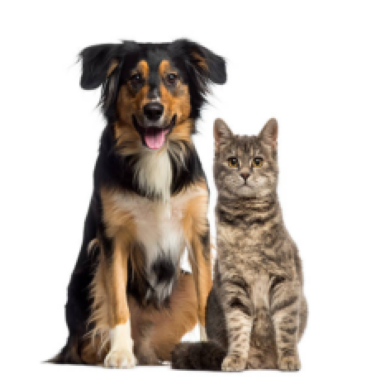

In [ ]:
# Obtain the image
image = Image.open('cat_dog.jpeg')
image = transform(image)
plot_image(image)

In [ ]:
# Loading the image
device = "cuda" if t.cuda.is_available() else "cpu"
model = model.to(device)
text_labels = ["a photo of a cat", "a photo of a dog"]
text_inputs = processor(text=text_labels, return_tensors="pt").to(device)
image_inputs = processor(images=image, return_tensors="pt")
image_inputs["pixel_values"] = image_inputs["pixel_values"].to(device)

with t.no_grad():
    outputs = model(**image_inputs, **text_inputs,output_hidden_states=True)
    logits = outputs.logits_per_image
    probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()

print("Logits:",logits,"Label probs:", probs)

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Logits: tensor([[24.8733, 25.2194]], device='cuda:0') Label probs: [[0.4143234  0.58567655]]


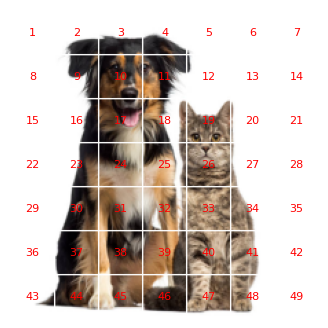

In [ ]:
from vit_prisma.visualization.visualize_image import display_grid_on_image

display_grid_on_image(image, patch_size=32)

In [ ]:
# Find cosine similarities
cosine_similarities = outputs.logits_per_image
print(f"cosine similarities: {cosine_similarities}")

cosine similarities: tensor([[24.8733, 25.2194]], device='cuda:0')


In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])


In [ ]:
# Get the embeddings
image_feats = outputs.image_embeds
text_feats = outputs.text_embeds
print(f"image_feats: {image_feats.shape}")
print(f"text_feats: {text_feats.shape}")

image_feats: torch.Size([1, 512])
text_feats: torch.Size([2, 512])


In [ ]:
# Cosine similarities for embeddings
cosine_similarities = t.cosine_similarity(image_feats, text_feats, dim = 1)
print(f"Cosine similarities: {cosine_similarities}")

Cosine similarities: tensor([0.2487, 0.2522], device='cuda:0')


In [ ]:
# Convert the tensor to a numpy array for plotting

import plotly.express as px
cosine_similarities_np = cosine_similarities.detach().cpu().numpy()

fig = px.bar(
    x = text_labels,
    y = cosine_similarities_np,
    title = "Cosine Similarities between Image and Text Features",
    labels = {'x': 'Text Labels', 'y': 'Cosine Similarities'},

)
fig.show()


# similarity_range = cosine_similarities.max() - cosine_similarities.min()
similarity_range = cosine_similarities.max() - cosine_similarities.min()
if similarity_range < 0.1:
  print("Poor alignment")

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Restarted llava (Python 3.10.16)

In [ ]:
import vit_prisma
from vit_prisma.utils.data_utils.imagenet.imagenet_dict import IMAGENET_DICT
from vit_prisma.utils import prisma_utils

#from transformers import CLIPProcessor, CLIPModel

from vit_prisma.utils.data_utils.imagenet.imagenet_utils import imagenet_index_from_word
import numpy as np
import torch as t
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from IPython.display import display, HTML

In [ ]:
# Helper function (ignore)
def plot_image(image):
  plt.figure()
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))

class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

transform = transforms.Compose([
    ConvertTo3Channels(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def plot_logit_boxplot(average_logits, labels):
  hovertexts = np.array([[IMAGENET_DICT[i] for _ in range(25)] for i in range(1000)])

  fig = go.Figure()
  data = []

  # if tensor, turn to numpy
  if isinstance(average_logits, torch.Tensor):
      average_logits = average_logits.detach().cpu().numpy()

  for i in range(average_logits.shape[1]):  # For each layer
      layer_logits = average_logits[:, i]
      hovertext = hovertexts[:, i]
      box = fig.add_trace(go.Box(
          y=layer_logits,
          name=f'{layer_labels[i]}',
          text=hovertext,
          hoverinfo='y+text',
          boxpoints='suspectedoutliers'
      ))
      data.append(box)


  means = np.mean(average_logits, axis=0)
  fig.add_trace(go.Scatter(
      x = layer_labels,
      y=means,
      mode='markers',
      name='Mean',
      # line=dict(color='gray'),
      marker=dict(size=4, color='red'),
  ))


  fig.update_layout(
      title='Raw Logit Values Per Layer (each dot is 1 ImageNet Class)',
      xaxis=dict(title='Layer'),
      yaxis=dict(title='Logit Values'),
      showlegend=False
  )

  fig.show()

In [ ]:
def plot_patched_component(patched_head, title=''):
  """
  Use for plotting Activation Patching.
  """

  fig = go.Figure(data=go.Heatmap(
      z=patched_head.detach().numpy(),
      colorscale='RdBu',  # You can choose any colorscale
      colorbar=dict(title='Value'),  # Customize the color bar
      hoverongaps=False
  ))
  fig.update_layout(
      title=title,
      xaxis_title='Attention Head',
      yaxis_title='Patch Number',
  )

  return fig

def imshow(tensor, **kwargs):
    """
    Use for Activation Patching.
    """
    px.imshow(
          prisma_utils.to_numpy(tensor),
          color_continuous_midpoint=0.0,
          color_continuous_scale="RdBu",
          **kwargs,
      ).show()

In [ ]:
# We'll use a text-image transformer. Loading the model
from transformers import CLIPProcessor, CLIPModel
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


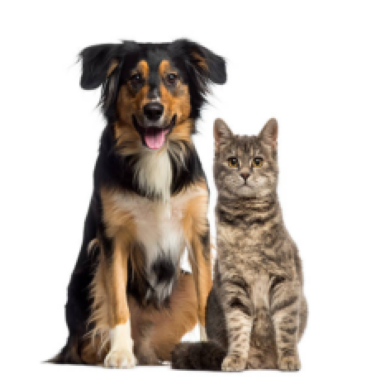

In [ ]:
# Obtain the image
image = Image.open('cat_dog.jpeg')
image = transform(image)
plot_image(image)

In [ ]:
# Loading the image
device = "cuda" if t.cuda.is_available() else "cpu"
model = model.to(device)
text_labels = ["a photo of a cat", "a photo of a dog"]
text_inputs = processor(text=text_labels, return_tensors="pt").to(device)
image_inputs = processor(images=image, return_tensors="pt")
image_inputs["pixel_values"] = image_inputs["pixel_values"].to(device)

with t.no_grad():
    outputs = model(**image_inputs, **text_inputs,output_hidden_states=True)
    logits = outputs.logits_per_image
    probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()

print("Logits:",logits,"Label probs:", probs)

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Logits: tensor([[24.8733, 25.2194]], device='cuda:0') Label probs: [[0.4143234  0.58567655]]


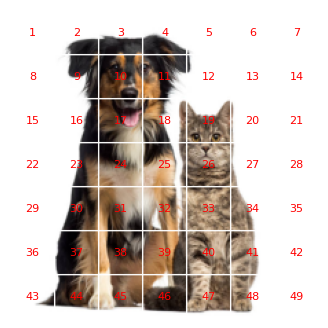

In [ ]:
from vit_prisma.visualization.visualize_image import display_grid_on_image

display_grid_on_image(image, patch_size=32)

In [ ]:
# Find cosine similarities
cosine_similarities = outputs.logits_per_image
print(f"cosine similarities: {cosine_similarities}")

cosine similarities: tensor([[24.8733, 25.2194]], device='cuda:0')


In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])


In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])


In [ ]:
# Get the embeddings
image_feats = outputs.image_embeds
text_feats = outputs.text_embeds
print(f"image_feats: {image_feats.shape}")
print(f"text_feats: {text_feats.shape}")

image_feats: torch.Size([1, 512])
text_feats: torch.Size([2, 512])


In [ ]:
# Cosine similarities for embeddings
cosine_similarities = t.cosine_similarity(image_feats, text_feats, dim = 1)
print(f"Cosine similarities: {cosine_similarities}")

Cosine similarities: tensor([0.2487, 0.2522], device='cuda:0')


In [ ]:
# Convert the tensor to a numpy array for plotting

import plotly.express as px
cosine_similarities_np = cosine_similarities.detach().cpu().numpy()

fig = px.bar(
    x = text_labels,
    y = cosine_similarities_np,
    title = "Cosine Similarities between Image and Text Features",
    labels = {'x': 'Text Labels', 'y': 'Cosine Similarities'},

)
fig.show()


# similarity_range = cosine_similarities.max() - cosine_similarities.min()
similarity_range = cosine_similarities.max() - cosine_similarities.min()
if similarity_range < 0.1:
  print("Poor alignment")

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
# Convert the tensor to a numpy array for plotting

import plotly.express as px
cosine_similarities_np = cosine_similarities.detach().cpu().numpy()
import plotly.io as pio
pio.renderers.default = "browser"  # or "vscode" or "notebook_connected"
fig = px.bar(
    x = text_labels,
    y = cosine_similarities_np,
    title = "Cosine Similarities between Image and Text Features",
    labels = {'x': 'Text Labels', 'y': 'Cosine Similarities'},

)
fig.show()


# similarity_range = cosine_similarities.max() - cosine_similarities.min()
similarity_range = cosine_similarities.max() - cosine_similarities.min()
if similarity_range < 0.1:
  print("Poor alignment")

Poor alignment


In [ ]:
# Finding the residual directions
# For Images (ViT/CLIP): the residual directions for a class in the column of the classification head weight matrix for that class. 
# For texts (CLIP): the residual direction for a label is the embedding for that label 
image_residual_directions = model.visual_projection.weight
with t.no_grad():
   text_residual_directions = model.get_text_features(**text_inputs)   

In [ ]:
# Accumulated residual
cat_index = imagenet_index_from_word("cat")
dog_index = imagenet_index_from_word("dog")
print(f"Tabby index: {cat_index}, Border Collie index: {dog_index}")

Tabby index: 30, Border Collie index: 153


In [ ]:
# Finding the residual directions
# For Images (ViT/CLIP): the residual directions for a class in the column of the classification head weight matrix for that class. 
# For texts (CLIP): the residual direction for a label is the embedding for that label 
cat_image_residual_directions = model.visual_projection.weight[cat_index]
dog_image_residual_directions = model.visual_projection.weight[dog_index]
print(f"Cat residual direction: {cat_image_residual_directions.shape}")
print(f"Dog residual direction: {dog_image_residual_directions.shape}")
with t.no_grad():
   text_residual_directions = model.get_text_features(**text_inputs)
cat_text_residual_directions = text_residual_directions[0]
dog_text_residual_directions = text_residual_directions[1]
print(f"Cat text residual direction: {cat_text_residual_directions.shape}")
print(f"Dog text residual direction: {dog_text_residual_directions.shape}")   

Cat residual direction: torch.Size([768])
Dog residual direction: torch.Size([768])
Cat text residual direction: torch.Size([512])
Dog text residual direction: torch.Size([512])


In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])


In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]
cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]

# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.post_layernorm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)


cat_vision_logit = einsum ('batch,d_model, d_model -> batch',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('batch,d_model, d_model -> batch',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('batch,d_model, d_model -> batch',
                    scaled_cls_text,
                    cat_text_residual_directions)
dog_text_logit = einsum ('batch,d_model, d_model -> batch',
                    scaled_cls_text,
                    dog_text_residual_directions)
# Add the bias for the cat class to the vision logit
if hasattr(model.visual_projection, 'bias'):
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if hasattr(model.text_projection, 'bias'):
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])


AttributeError: 'CLIPTextTransformer' object has no attribute 'post_layernorm'

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]
cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]

# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)


cat_vision_logit = einsum ('batch,d_model, d_model -> batch',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('batch,d_model, d_model -> batch',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('batch,d_model, d_model -> batch',
                    scaled_cls_text,
                    cat_text_residual_directions)
dog_text_logit = einsum ('batch,d_model, d_model -> batch',
                    scaled_cls_text,
                    dog_text_residual_directions)
# Add the bias for the cat class to the vision logit
if hasattr(model.visual_projection, 'bias'):
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if hasattr(model.text_projection, 'bias'):
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])


RuntimeError: einsum(): fewer operands were provided than specified in the equation

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]
cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]

# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)


cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('batch,d_model, d_model -> batch',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    cat_text_residual_directions[0])
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    dog_text_residual_directions[0])
# Add the bias for the cat class to the vision logit
if hasattr(model.visual_projection, 'bias'):
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if hasattr(model.text_projection, 'bias'):
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])


RuntimeError: einsum(): fewer operands were provided than specified in the equation

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]
cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]

# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)


cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    cat_text_residual_directions[0])
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    dog_text_residual_directions[0])
# Add the bias for the cat class to the vision logit
if hasattr(model.visual_projection, 'bias'):
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if hasattr(model.text_projection, 'bias'):
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])


RuntimeError: einsum(): the number of subscripts in the equation (1) does not match the number of dimensions (0) for operand 1 and no ellipsis was given

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]

# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)


cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    dog_text_residual_directions)
# Add the bias for the cat class to the vision logit
if hasattr(model.visual_projection, 'bias'):
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if hasattr(model.text_projection, 'bias'):
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])


TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]

# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    dog_text_residual_directions)
# Add the bias for the cat class to the vision logit
if hasattr(model.visual_projection, 'bias'):
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if hasattr(model.text_projection, 'bias'):
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])


TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Finding the residual directions
# For Images (ViT/CLIP): the residual directions for a class in the column of the classification head weight matrix for that class. 
# For texts (CLIP): the residual direction for a label is the embedding for that label 
cat_image_residual_directions = model.visual_projection.weight[cat_index]
dog_image_residual_directions = model.visual_projection.weight[dog_index]
print(f"Cat residual direction: {cat_image_residual_directions.shape}")
print(f"Dog residual direction: {dog_image_residual_directions.shape}")
with t.no_grad():
   text_residual_directions = model.get_text_features(**text_inputs)
cat_text_residual_directions = text_residual_directions[0]
dog_text_residual_directions = text_residual_directions[1]
print(f"Cat text residual direction: {cat_text_residual_directions.shape}")
print(f"Dog text residual direction: {dog_text_residual_directions.shape}")   

Cat residual direction: torch.Size([768])
Dog residual direction: torch.Size([768])
Cat text residual direction: torch.Size([512])
Dog text residual direction: torch.Size([512])


In [ ]:
# Accumulated residual
cat_index = imagenet_index_from_word("cat")
dog_index = imagenet_index_from_word("dog")
print(f"Tabby index: {cat_index}, Border Collie index: {dog_index}")

Tabby index: 30, Border Collie index: 153


In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]

# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    dog_text_residual_directions)
# Add the bias for the cat class to the vision logit
if hasattr(model.visual_projection, 'bias'):
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if hasattr(model.text_projection, 'bias',None) is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])


TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]

# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    dog_text_residual_directions)
# Add the bias for the cat class to the vision logit
if hasattr(model.visual_projection, 'bias',None) is not None:
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if hasattr(model.text_projection, 'bias',None) is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])


TypeError: hasattr expected 2 arguments, got 3

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]

# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    dog_text_residual_directions)
# Add the bias for the cat class to the vision logit
if hasattr(model.visual_projection, 'bias') is not None:
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if hasattr(model.text_projection, 'bias') is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])


TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]

# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    dog_text_residual_directions)
# Add the bias for the cat class to the vision logit
if hasattr(model.visual_projection, None) is not None:
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if hasattr(model.text_projection, None) is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])


TypeError: hasattr(): attribute name must be string

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]

# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    dog_text_residual_directions)
# Add the bias for the cat class to the vision logit
if hasattr(model.visual_projection, 'None') is not None:
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if hasattr(model.text_projection, 'None') is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])


TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]

# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    dog_text_residual_directions)
# Add the bias for the cat class to the vision logit
if getattr(model.visual_projection, 'None') is not None:
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if getattr(model.text_projection, 'None') is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])


AttributeError: 'Linear' object has no attribute 'None'

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]

# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    dog_text_residual_directions)
# Add the bias for the cat class to the vision logit
if getattr(model.visual_projection, 'bias',None) is not None:
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if getattr(model.text_projection, 'bias', None) is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])
No bias in the visual projection layer.
No bias in the text projection layer.
Cat vision logit: -0.199
Dog vision logit: -0.063


RuntimeError: a Tensor with 2 elements cannot be converted to Scalar

In [ ]:
# Finding the residual directions
# For Images (ViT/CLIP): the residual directions for a class in the column of the classification head weight matrix for that class. 
# For texts (CLIP): the residual direction for a label is the embedding for that label 
cat_image_residual_directions = model.visual_projection.weight[cat_index]
dog_image_residual_directions = model.visual_projection.weight[dog_index]
print(f"Cat residual direction: {cat_image_residual_directions.shape}")
print(f"Dog residual direction: {dog_image_residual_directions.shape}")
with t.no_grad():
   text_residual_directions = model.get_text_features(**text_inputs)
cat_text_residual_directions = text_residual_directions[0]
dog_text_residual_directions = text_residual_directions[1]
print(f"Cat text residual direction: {cat_text_residual_directions.shape}")
print(f"Dog text residual direction: {dog_text_residual_directions.shape}")   

Cat residual direction: torch.Size([768])
Dog residual direction: torch.Size([768])
Cat text residual direction: torch.Size([512])
Dog text residual direction: torch.Size([512])


In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]

# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    dog_text_residual_directions)
print(f"Cat vision logit: {cat_vision_logit.shape}")
print(f"Dog vision logit: {dog_vision_logit.shape}")
print(f"Cat text logit: {cat_text_logit.shape}")
print(f"Dog text logit: {dog_text_logit.shape}")
# Add the bias for the cat class to the vision logit
if getattr(model.visual_projection, 'bias',None) is not None:
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if getattr(model.text_projection, 'bias', None) is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])
Cat vision logit: torch.Size([1])
Dog vision logit: torch.Size([1])
Cat text logit: torch.Size([2])
Dog text logit: torch.Size([2])
No bias in the visual projection layer.
No bias in the text projection layer.
Cat vision logit: -0.199
Dog vision logit: -0.063


RuntimeError: a Tensor with 2 elements cannot be converted to Scalar

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]

# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    dog_text_residual_directions)
print(f"Cat vision logit: {cat_vision_logit.shape}")
print(f"Dog vision logit: {dog_vision_logit.shape}")
print(f"Cat text logit: {cat_text_logit}")
print(f"Dog text logit: {dog_text_logit}")
# Add the bias for the cat class to the vision logit
if getattr(model.visual_projection, 'bias',None) is not None:
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if getattr(model.text_projection, 'bias', None) is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])
Cat vision logit: torch.Size([1])
Dog vision logit: torch.Size([1])
Cat text logit: tensor([5.0624, 5.0624], device='cuda:0', grad_fn=<ViewBackward0>)
Dog text logit: tensor([2.8705, 2.8705], device='cuda:0', grad_fn=<ViewBackward0>)
No bias in the visual projection layer.
No bias in the text projection layer.
Cat vision logit: -0.199
Dog vision logit: -0.063


RuntimeError: a Tensor with 2 elements cannot be converted to Scalar

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]

# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    cat_text_residual_directions)[0]
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    dog_text_residual_directions)[0]
print(f"Cat vision logit: {cat_vision_logit.shape}")
print(f"Dog vision logit: {dog_vision_logit.shape}")
print(f"Cat text logit: {cat_text_logit}")
print(f"Dog text logit: {dog_text_logit}")
# Add the bias for the cat class to the vision logit
if getattr(model.visual_projection, 'bias',None) is not None:
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if getattr(model.text_projection, 'bias', None) is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])
Cat vision logit: torch.Size([1])
Dog vision logit: torch.Size([1])
Cat text logit: 5.062414169311523
Dog text logit: 2.870466947555542
No bias in the visual projection layer.
No bias in the text projection layer.
Cat vision logit: -0.199
Dog vision logit: -0.063
Cat text logit: 5.062
Dog text logit: 2.87


In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]
print(f"Shape of the CLS token in vision model: {cls_vision_residual_stream.shape}")
print(f"Shape of the CLS token in text model: {cls_text_residual_stream.shape}")
# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    cat_text_residual_directions)[0]
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    dog_text_residual_directions)[0]
print(f"Cat vision logit: {cat_vision_logit.shape}")
print(f"Dog vision logit: {dog_vision_logit.shape}")
print(f"Cat text logit: {cat_text_logit}")
print(f"Dog text logit: {dog_text_logit}")
# Add the bias for the cat class to the vision logit
if getattr(model.visual_projection, 'bias',None) is not None:
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if getattr(model.text_projection, 'bias', None) is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Shape of the CLS token in vision model: torch.Size([1, 768])
Shape of the CLS token in text model: torch.Size([2, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])
Cat vision logit: torch.Size([1])
Dog vision logit: torch.Size([1])
Cat text logit: 5.062414169311523
Dog text logit: 2.870466947555542
No bias in the visual projection layer.
No bias in the text projection layer.
Cat vision logit: -0.199
Dog vision logit: -0.063
Cat text logit: 5.062
Dog text logit: 2.87


In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]
print(f"Shape of the CLS token in vision model: {cls_vision_residual_stream.shape}")
print(f"Shape of the CLS token in text model: {cls_text_residual_stream.shape}")
# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    dog_text_residual_directions)
print(f"Cat vision logit: {cat_vision_logit.shape}")
print(f"Dog vision logit: {dog_vision_logit.shape}")
print(f"Cat text logit: {cat_text_logit}")
print(f"Dog text logit: {dog_text_logit}")
# Add the bias for the cat class to the vision logit
if getattr(model.visual_projection, 'bias',None) is not None:
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if getattr(model.text_projection, 'bias', None) is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Shape of the CLS token in vision model: torch.Size([1, 768])
Shape of the CLS token in text model: torch.Size([2, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])
Cat vision logit: torch.Size([1])
Dog vision logit: torch.Size([1])
Cat text logit: 5.062414646148682
Dog text logit: 2.8704676628112793
No bias in the visual projection layer.
No bias in the text projection layer.
Cat vision logit: -0.199
Dog vision logit: -0.063
Cat text logit: 5.062
Dog text logit: 2.87


Connected to llava (Python 3.10.16)

In [ ]:
import vit_prisma
from vit_prisma.utils.data_utils.imagenet.imagenet_dict import IMAGENET_DICT
from vit_prisma.utils import prisma_utils

#from transformers import CLIPProcessor, CLIPModel

from vit_prisma.utils.data_utils.imagenet.imagenet_utils import imagenet_index_from_word
import numpy as np
import torch as t
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from IPython.display import display, HTML

In [ ]:
# Helper function (ignore)
def plot_image(image):
  plt.figure()
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))

class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

transform = transforms.Compose([
    ConvertTo3Channels(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def plot_logit_boxplot(average_logits, labels):
  hovertexts = np.array([[IMAGENET_DICT[i] for _ in range(25)] for i in range(1000)])

  fig = go.Figure()
  data = []

  # if tensor, turn to numpy
  if isinstance(average_logits, torch.Tensor):
      average_logits = average_logits.detach().cpu().numpy()

  for i in range(average_logits.shape[1]):  # For each layer
      layer_logits = average_logits[:, i]
      hovertext = hovertexts[:, i]
      box = fig.add_trace(go.Box(
          y=layer_logits,
          name=f'{layer_labels[i]}',
          text=hovertext,
          hoverinfo='y+text',
          boxpoints='suspectedoutliers'
      ))
      data.append(box)


  means = np.mean(average_logits, axis=0)
  fig.add_trace(go.Scatter(
      x = layer_labels,
      y=means,
      mode='markers',
      name='Mean',
      # line=dict(color='gray'),
      marker=dict(size=4, color='red'),
  ))


  fig.update_layout(
      title='Raw Logit Values Per Layer (each dot is 1 ImageNet Class)',
      xaxis=dict(title='Layer'),
      yaxis=dict(title='Logit Values'),
      showlegend=False
  )

  fig.show()

In [ ]:
def plot_patched_component(patched_head, title=''):
  """
  Use for plotting Activation Patching.
  """

  fig = go.Figure(data=go.Heatmap(
      z=patched_head.detach().numpy(),
      colorscale='RdBu',  # You can choose any colorscale
      colorbar=dict(title='Value'),  # Customize the color bar
      hoverongaps=False
  ))
  fig.update_layout(
      title=title,
      xaxis_title='Attention Head',
      yaxis_title='Patch Number',
  )

  return fig

def imshow(tensor, **kwargs):
    """
    Use for Activation Patching.
    """
    px.imshow(
          prisma_utils.to_numpy(tensor),
          color_continuous_midpoint=0.0,
          color_continuous_scale="RdBu",
          **kwargs,
      ).show()

In [ ]:
import vit_prisma
from vit_prisma.utils.data_utils.imagenet.imagenet_dict import IMAGENET_DICT
from vit_prisma.utils import prisma_utils

#from transformers import CLIPProcessor, CLIPModel

from vit_prisma.utils.data_utils.imagenet.imagenet_utils import imagenet_index_from_word
import numpy as np
import torch as t
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from IPython.display import display, HTML

In [ ]:
# Helper function (ignore)
def plot_image(image):
  plt.figure()
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))

class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

transform = transforms.Compose([
    ConvertTo3Channels(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def plot_logit_boxplot(average_logits, labels):
  hovertexts = np.array([[IMAGENET_DICT[i] for _ in range(25)] for i in range(1000)])

  fig = go.Figure()
  data = []

  # if tensor, turn to numpy
  if isinstance(average_logits, torch.Tensor):
      average_logits = average_logits.detach().cpu().numpy()

  for i in range(average_logits.shape[1]):  # For each layer
      layer_logits = average_logits[:, i]
      hovertext = hovertexts[:, i]
      box = fig.add_trace(go.Box(
          y=layer_logits,
          name=f'{layer_labels[i]}',
          text=hovertext,
          hoverinfo='y+text',
          boxpoints='suspectedoutliers'
      ))
      data.append(box)


  means = np.mean(average_logits, axis=0)
  fig.add_trace(go.Scatter(
      x = layer_labels,
      y=means,
      mode='markers',
      name='Mean',
      # line=dict(color='gray'),
      marker=dict(size=4, color='red'),
  ))


  fig.update_layout(
      title='Raw Logit Values Per Layer (each dot is 1 ImageNet Class)',
      xaxis=dict(title='Layer'),
      yaxis=dict(title='Logit Values'),
      showlegend=False
  )

  fig.show()

In [ ]:
def plot_patched_component(patched_head, title=''):
  """
  Use for plotting Activation Patching.
  """

  fig = go.Figure(data=go.Heatmap(
      z=patched_head.detach().numpy(),
      colorscale='RdBu',  # You can choose any colorscale
      colorbar=dict(title='Value'),  # Customize the color bar
      hoverongaps=False
  ))
  fig.update_layout(
      title=title,
      xaxis_title='Attention Head',
      yaxis_title='Patch Number',
  )

  return fig

def imshow(tensor, **kwargs):
    """
    Use for Activation Patching.
    """
    px.imshow(
          prisma_utils.to_numpy(tensor),
          color_continuous_midpoint=0.0,
          color_continuous_scale="RdBu",
          **kwargs,
      ).show()

In [ ]:
# We'll use a text-image transformer. Loading the model
from transformers import CLIPProcessor, CLIPModel
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


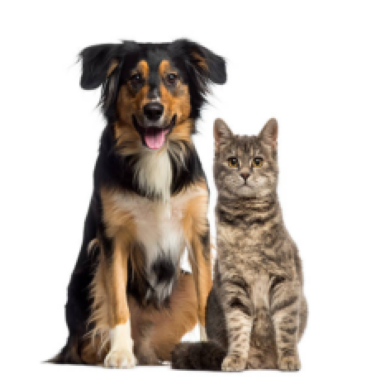

In [ ]:
# Obtain the image
image = Image.open('cat_dog.jpeg')
image = transform(image)
plot_image(image)

In [ ]:
# Loading the image
device = "cuda" if t.cuda.is_available() else "cpu"
model = model.to(device)
text_labels = ["a photo of a cat", "a photo of a dog"]
text_inputs = processor(text=text_labels, return_tensors="pt").to(device)
image_inputs = processor(images=image, return_tensors="pt")
image_inputs["pixel_values"] = image_inputs["pixel_values"].to(device)

with t.no_grad():
    outputs = model(**image_inputs, **text_inputs,output_hidden_states=True)
    logits = outputs.logits_per_image
    probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()

print("Logits:",logits,"Label probs:", probs)

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Logits: tensor([[24.8733, 25.2194]], device='cuda:0') Label probs: [[0.4143234  0.58567655]]


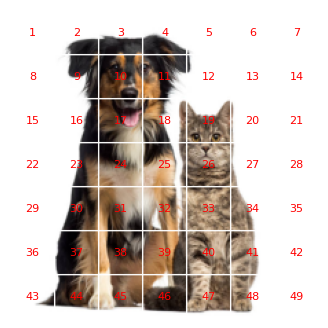

In [ ]:
from vit_prisma.visualization.visualize_image import display_grid_on_image

display_grid_on_image(image, patch_size=32)

In [ ]:
# Find cosine similarities
cosine_similarities = outputs.logits_per_image
print(f"cosine similarities: {cosine_similarities}")

cosine similarities: tensor([[24.8733, 25.2194]], device='cuda:0')


In [ ]:
# Find cosine similarities
cosine_similarities = t.cosine_similarity(outputs, dim=0)
print(f"cosine similarities: {cosine_similarities}")

TypeError: cosine_similarity(): argument 'x1' (position 1) must be Tensor, not CLIPOutput

In [ ]:
# Find cosine similarities
cosine_similarities = t.cosine_similarity(logits, dim=0)
print(f"cosine similarities: {cosine_similarities}")

TypeError: cosine_similarity() missing 1 required positional arguments: "x2"

In [ ]:
# Find cosine similarities
cosine_similarities = t.cosine_similarity(logits[0], logits[1], dim=0)
print(f"cosine similarities: {cosine_similarities}")

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [ ]:
# Loading the image
device = "cuda" if t.cuda.is_available() else "cpu"
model = model.to(device)
text_labels = ["a photo of a cat", "a photo of a dog"]
text_inputs = processor(text=text_labels, return_tensors="pt").to(device)
image_inputs = processor(images=image, return_tensors="pt")
image_inputs["pixel_values"] = image_inputs["pixel_values"].to(device)

with t.no_grad():
    outputs = model(**image_inputs, **text_inputs,output_hidden_states=True)
    logits = outputs.logits_per_image
    probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()

print("Logits:",logits,"Label probs:", probs)

Logits: tensor([[24.8733, 25.2194]], device='cuda:0') Label probs: [[0.4143234  0.58567655]]


In [ ]:
# Loading the image
device = "cuda" if t.cuda.is_available() else "cpu"
model = model.to(device)
text_labels = ["a photo of a cat", "a photo of a dog"]
text_inputs = processor(text=text_labels, return_tensors="pt").to(device)
image_inputs = processor(images=image, return_tensors="pt")
image_inputs["pixel_values"] = image_inputs["pixel_values"].to(device)

with t.no_grad():
    outputs = model(**image_inputs, **text_inputs,output_hidden_states=True)
    image_logits = outputs.logits_per_image
    text_logits = outputs.logits_per_text
    probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()

print("Logits:",logits,"Label probs:", probs)

Logits: tensor([[24.8733, 25.2194]], device='cuda:0') Label probs: [[0.4143234  0.58567655]]


In [ ]:
# Loading the image
device = "cuda" if t.cuda.is_available() else "cpu"
model = model.to(device)
text_labels = ["a photo of a cat", "a photo of a dog"]
text_inputs = processor(text=text_labels, return_tensors="pt").to(device)
image_inputs = processor(images=image, return_tensors="pt")
image_inputs["pixel_values"] = image_inputs["pixel_values"].to(device)

with t.no_grad():
    outputs = model(**image_inputs, **text_inputs,output_hidden_states=True)
    image_logits = outputs.logits_per_image
    text_logits = outputs.logits_per_text
    probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()

print("Image Logits:",image_logits, "Text Logits:", text_logits, "Label probs:", probs)

Image Logits: tensor([[24.8733, 25.2194]], device='cuda:0') Text Logits: tensor([[24.8733],
        [25.2194]], device='cuda:0') Label probs: [[0.4143234  0.58567655]]


In [ ]:
# Find cosine similarities
cosine_similarities = t.cosine_similarity(image_logits, text_logits, dim=0)
print(f"cosine similarities: {cosine_similarities}")

cosine similarities: tensor([1.0000, 1.0000], device='cuda:0')


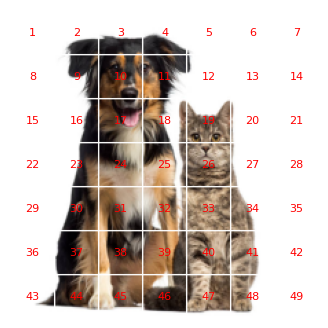

In [ ]:
from vit_prisma.visualization.visualize_image import display_grid_on_image

display_grid_on_image(image, patch_size=32)

In [ ]:
# Accumulated residual
cat_index = imagenet_index_from_word("cat")
dog_index = imagenet_index_from_word("dog")
print(f"Tabby index: {cat_index}, Border Collie index: {dog_index}")

Tabby index: 30, Border Collie index: 153


In [ ]:
# Finding the residual directions
# For Images (ViT/CLIP): the residual directions for a class in the column of the classification head weight matrix for that class. 
# For texts (CLIP): the residual direction for a label is the embedding for that label 
cat_image_residual_directions = model.visual_projection.weight[cat_index]
dog_image_residual_directions = model.visual_projection.weight[dog_index]
print(f"Cat residual direction: {cat_image_residual_directions.shape}")
print(f"Dog residual direction: {dog_image_residual_directions.shape}")
with t.no_grad():
   text_residual_directions = model.get_text_features(**text_inputs)
cat_text_residual_directions = text_residual_directions[0]
dog_text_residual_directions = text_residual_directions[1]
print(f"Cat text residual direction: {cat_text_residual_directions.shape}")
print(f"Dog text residual direction: {dog_text_residual_directions.shape}")   

Cat residual direction: torch.Size([768])
Dog residual direction: torch.Size([768])
Cat text residual direction: torch.Size([512])
Dog text residual direction: torch.Size([512])


In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]
print(f"Shape of the CLS token in vision model: {cls_vision_residual_stream.shape}")
print(f"Shape of the CLS token in text model: {cls_text_residual_stream.shape}")
# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    dog_text_residual_directions)
print(f"Cat vision logit: {cat_vision_logit.shape}")
print(f"Dog vision logit: {dog_vision_logit.shape}")
print(f"Cat text logit: {cat_text_logit}")
print(f"Dog text logit: {dog_text_logit}")
# Add the bias for the cat class to the vision logit
if getattr(model.visual_projection, 'bias',None) is not None:
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if getattr(model.text_projection, 'bias', None) is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Shape of the CLS token in vision model: torch.Size([1, 768])
Shape of the CLS token in text model: torch.Size([2, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])
Cat vision logit: torch.Size([1])
Dog vision logit: torch.Size([1])
Cat text logit: 5.062414646148682
Dog text logit: 2.8704676628112793
No bias in the visual projection layer.
No bias in the text projection layer.
Cat vision logit: -0.199
Dog vision logit: -0.063
Cat text logit: 5.062
Dog text logit: 2.87


In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]
print(f"Shape of the CLS token in vision model: {cls_vision_residual_stream.shape}")
print(f"Shape of the CLS token in text model: {cls_text_residual_stream.shape}")
# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    dog_text_residual_directions)
print(f"Cat vision logit: {cat_vision_logit.shape}")
print(f"Dog vision logit: {dog_vision_logit.shape}")
print(f"Cat text logit: {cat_text_logit}")
print(f"Dog text logit: {dog_text_logit}")
# Add the bias for the cat class to the vision logit
if getattr(model.visual_projection, 'bias',None) is not None:
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if getattr(model.text_projection, 'bias', None) is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Tabby cat vision logit taken directly from the model's output:{round(image_logits[0, cat_index].item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Dog border collie vision logit taken directly from the model's output: {round(image_logits[0, dog_index].item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Cat tabby text logit taken directly from the model's output: {round(text_logits[0][1].item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")
print(f"Dog border collie text logit taken directly from the model's output: {round(text_logits[0][1].item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Shape of the CLS token in vision model: torch.Size([1, 768])
Shape of the CLS token in text model: torch.Size([2, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])
Cat vision logit: torch.Size([1])
Dog vision logit: torch.Size([1])
Cat text logit: 5.062414646148682
Dog text logit: 2.8704676628112793
No bias in the visual projection layer.
No bias in the text projection layer.
Cat vision logit: -0.199


IndexError: index 30 is out of bounds for dimension 1 with size 2

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]
print(f"Shape of the CLS token in vision model: {cls_vision_residual_stream.shape}")
print(f"Shape of the CLS token in text model: {cls_text_residual_stream.shape}")
# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    dog_text_residual_directions)
print(f"Cat vision logit: {cat_vision_logit.shape}")
print(f"Dog vision logit: {dog_vision_logit.shape}")
print(f"Cat text logit: {cat_text_logit}")
print(f"Dog text logit: {dog_text_logit}")
# Add the bias for the cat class to the vision logit
if getattr(model.visual_projection, 'bias',None) is not None:
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if getattr(model.text_projection, 'bias', None) is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Tabby cat vision logit taken directly from the model's output:{round(image_logits[0].item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Dog border collie vision logit taken directly from the model's output: {round(image_logits[1].item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Cat tabby text logit taken directly from the model's output: {round(text_logits[0][1].item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")
print(f"Dog border collie text logit taken directly from the model's output: {round(text_logits[0][1].item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Shape of the CLS token in vision model: torch.Size([1, 768])
Shape of the CLS token in text model: torch.Size([2, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])
Cat vision logit: torch.Size([1])
Dog vision logit: torch.Size([1])
Cat text logit: 5.062414646148682
Dog text logit: 2.8704676628112793
No bias in the visual projection layer.
No bias in the text projection layer.
Cat vision logit: -0.199


RuntimeError: a Tensor with 2 elements cannot be converted to Scalar

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]
print(f"Shape of the CLS token in vision model: {cls_vision_residual_stream.shape}")
print(f"Shape of the CLS token in text model: {cls_text_residual_stream.shape}")
# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    dog_text_residual_directions)
print(f"Cat vision logit: {cat_vision_logit.shape}")
print(f"Dog vision logit: {dog_vision_logit.shape}")
print(f"Cat text logit: {cat_text_logit}")
print(f"Dog text logit: {dog_text_logit}")
# Add the bias for the cat class to the vision logit
if getattr(model.visual_projection, 'bias',None) is not None:
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if getattr(model.text_projection, 'bias', None) is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Tabby cat vision logit taken directly from the model's output:{round(image_logits.item()[0],3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Dog border collie vision logit taken directly from the model's output: {round(image_logits[1].item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Cat tabby text logit taken directly from the model's output: {round(text_logits[0][1].item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")
print(f"Dog border collie text logit taken directly from the model's output: {round(text_logits[0][1].item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Shape of the CLS token in vision model: torch.Size([1, 768])
Shape of the CLS token in text model: torch.Size([2, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])
Cat vision logit: torch.Size([1])
Dog vision logit: torch.Size([1])
Cat text logit: 5.062414646148682
Dog text logit: 2.8704676628112793
No bias in the visual projection layer.
No bias in the text projection layer.
Cat vision logit: -0.199


RuntimeError: a Tensor with 2 elements cannot be converted to Scalar

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]
print(f"Shape of the CLS token in vision model: {cls_vision_residual_stream.shape}")
print(f"Shape of the CLS token in text model: {cls_text_residual_stream.shape}")
# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    dog_text_residual_directions)
print(f"Cat vision logit: {cat_vision_logit.shape}")
print(f"Dog vision logit: {dog_vision_logit.shape}")
print(f"Cat text logit: {cat_text_logit}")
print(f"Dog text logit: {dog_text_logit}")
# Add the bias for the cat class to the vision logit
if getattr(model.visual_projection, 'bias',None) is not None:
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if getattr(model.text_projection, 'bias', None) is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Tabby cat vision logit taken directly from the model's output:{round(image_logits[0,cat_index].item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Dog border collie vision logit taken directly from the model's output: {round(image_logits[0,dog_index].item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Cat tabby text logit taken directly from the model's output: {round(text_logits[0][0].item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")
print(f"Dog border collie text logit taken directly from the model's output: {round(text_logits[0][1].item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Shape of the CLS token in vision model: torch.Size([1, 768])
Shape of the CLS token in text model: torch.Size([2, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])
Cat vision logit: torch.Size([1])
Dog vision logit: torch.Size([1])
Cat text logit: 5.062414646148682
Dog text logit: 2.8704676628112793
No bias in the visual projection layer.
No bias in the text projection layer.
Cat vision logit: -0.199


IndexError: index 30 is out of bounds for dimension 1 with size 2

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]
print(f"Shape of the CLS token in vision model: {cls_vision_residual_stream.shape}")
print(f"Shape of the CLS token in text model: {cls_text_residual_stream.shape}")
# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    dog_text_residual_directions)
print(f"Cat vision logit: {cat_vision_logit.shape}")
print(f"Dog vision logit: {dog_vision_logit.shape}")
print(f"Cat text logit: {cat_text_logit}")
print(f"Dog text logit: {dog_text_logit}")
# Add the bias for the cat class to the vision logit
if getattr(model.visual_projection, 'bias',None) is not None:
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if getattr(model.text_projection, 'bias', None) is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Tabby cat vision logit taken directly from the model's output:{round(image_logits[0][0].item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Dog border collie vision logit taken directly from the model's output: {round(image_logits[0][1].item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Cat tabby text logit taken directly from the model's output: {round(text_logits[0][0].item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")
print(f"Dog border collie text logit taken directly from the model's output: {round(text_logits[0][1].item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Shape of the CLS token in vision model: torch.Size([1, 768])
Shape of the CLS token in text model: torch.Size([2, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])
Cat vision logit: torch.Size([1])
Dog vision logit: torch.Size([1])
Cat text logit: 5.062414646148682
Dog text logit: 2.8704676628112793
No bias in the visual projection layer.
No bias in the text projection layer.
Cat vision logit: -0.199
Tabby cat vision logit taken directly from the model's output:24.873
Dog vision logit: -0.063
Dog border collie vision logit taken directly from the model's output: 25.219
Cat text logit: 5.062
Cat tabby text logit taken 

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]
print(f"Shape of the CLS token in vision model: {cls_vision_residual_stream.shape}")
print(f"Shape of the CLS token in text model: {cls_text_residual_stream.shape}")
# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    dog_text_residual_directions)
print(f"Cat vision logit: {cat_vision_logit.shape}")
print(f"Dog vision logit: {dog_vision_logit.shape}")
print(f"Cat text logit: {cat_text_logit}")
print(f"Dog text logit: {dog_text_logit}")
# Add the bias for the cat class to the vision logit
if getattr(model.visual_projection, 'bias',None) is not None:
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if getattr(model.text_projection, 'bias', None) is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Tabby cat vision logit taken directly from the model's output:{round(image_logits[0, cat_index].item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Dog border collie vision logit taken directly from the model's output: {round(image_logits[0,dog_index].item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Cat tabby text logit taken directly from the model's output: {round(text_logits[0][0].item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")
print(f"Dog border collie text logit taken directly from the model's output: {round(text_logits[0][1].item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Shape of the CLS token in vision model: torch.Size([1, 768])
Shape of the CLS token in text model: torch.Size([2, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])
Cat vision logit: torch.Size([1])
Dog vision logit: torch.Size([1])
Cat text logit: 5.062414646148682
Dog text logit: 2.8704676628112793
No bias in the visual projection layer.
No bias in the text projection layer.
Cat vision logit: -0.199


IndexError: index 30 is out of bounds for dimension 1 with size 2

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]
print(f"Shape of the CLS token in vision model: {cls_vision_residual_stream.shape}")
print(f"Shape of the CLS token in text model: {cls_text_residual_stream.shape}")
# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    dog_text_residual_directions)
print(f"Cat vision logit: {cat_vision_logit.shape}")
print(f"Dog vision logit: {dog_vision_logit.shape}")
print(f"Cat text logit: {cat_text_logit}")
print(f"Dog text logit: {dog_text_logit}")
# Add the bias for the cat class to the vision logit
if getattr(model.visual_projection, 'bias',None) is not None:
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if getattr(model.text_projection, 'bias', None) is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Tabby cat vision logit taken directly from the model's output:{round(image_logits[0,0].item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Dog border collie vision logit taken directly from the model's output: {round(image_logits[0,1].item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Cat tabby text logit taken directly from the model's output: {round(text_logits[0,0].item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")
print(f"Dog border collie text logit taken directly from the model's output: {round(text_logits[0,1].item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Shape of the CLS token in vision model: torch.Size([1, 768])
Shape of the CLS token in text model: torch.Size([2, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])
Cat vision logit: torch.Size([1])
Dog vision logit: torch.Size([1])
Cat text logit: 5.062414646148682
Dog text logit: 2.8704676628112793
No bias in the visual projection layer.
No bias in the text projection layer.
Cat vision logit: -0.199
Tabby cat vision logit taken directly from the model's output:24.873
Dog vision logit: -0.063
Dog border collie vision logit taken directly from the model's output: 25.219
Cat text logit: 5.062
Cat tabby text logit taken 

IndexError: index 1 is out of bounds for dimension 1 with size 1

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]
print(f"Shape of the CLS token in vision model: {cls_vision_residual_stream.shape}")
print(f"Shape of the CLS token in text model: {cls_text_residual_stream.shape}")
# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    dog_text_residual_directions)
print(f"Cat vision logit: {cat_vision_logit.shape}")
print(f"Dog vision logit: {dog_vision_logit.shape}")
print(f"Cat text logit: {cat_text_logit}")
print(f"Dog text logit: {dog_text_logit}")
# Add the bias for the cat class to the vision logit
if getattr(model.visual_projection, 'bias',None) is not None:
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if getattr(model.text_projection, 'bias', None) is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Tabby cat vision logit taken directly from the model's output:{round(image_logits[0,0].item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Dog border collie vision logit taken directly from the model's output: {round(image_logits[0,1].item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Cat tabby text logit taken directly from the model's output: {round(text_logits[0,0].item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")
print(f"Dog border collie text logit taken directly from the model's output: {round(text_logits[0,1].item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Shape of the CLS token in vision model: torch.Size([1, 768])
Shape of the CLS token in text model: torch.Size([2, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])
Cat vision logit: torch.Size([1])
Dog vision logit: torch.Size([1])
Cat text logit: 5.062414646148682
Dog text logit: 2.8704676628112793
No bias in the visual projection layer.
No bias in the text projection layer.
Cat vision logit: -0.199
Tabby cat vision logit taken directly from the model's output:24.873
Dog vision logit: -0.063
Dog border collie vision logit taken directly from the model's output: 25.219
Cat text logit: 5.062
Cat tabby text logit taken 

IndexError: index 1 is out of bounds for dimension 1 with size 1

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]
print(f"Shape of the CLS token in vision model: {cls_vision_residual_stream.shape}")
print(f"Shape of the CLS token in text model: {cls_text_residual_stream.shape}")
# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    dog_text_residual_directions)
print(f"Cat vision logit: {cat_vision_logit.shape}")
print(f"Dog vision logit: {dog_vision_logit.shape}")
print(f"Cat text logit: {cat_text_logit}")
print(f"Dog text logit: {dog_text_logit}")
# Add the bias for the cat class to the vision logit
if getattr(model.visual_projection, 'bias',None) is not None:
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if getattr(model.text_projection, 'bias', None) is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Tabby cat vision logit taken directly from the model's output:{round(image_logits[0,0].item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Dog border collie vision logit taken directly from the model's output: {round(image_logits[0,1].item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Cat tabby text logit taken directly from the model's output: {round(text_logits[0,0].item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")
print(f"Dog border collie text logit taken directly from the model's output: {round(text_logits[1,0].item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Shape of the CLS token in vision model: torch.Size([1, 768])
Shape of the CLS token in text model: torch.Size([2, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])
Cat vision logit: torch.Size([1])
Dog vision logit: torch.Size([1])
Cat text logit: 5.062414646148682
Dog text logit: 2.8704676628112793
No bias in the visual projection layer.
No bias in the text projection layer.
Cat vision logit: -0.199
Tabby cat vision logit taken directly from the model's output:24.873
Dog vision logit: -0.063
Dog border collie vision logit taken directly from the model's output: 25.219
Cat text logit: 5.062
Cat tabby text logit taken 

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]
print(f"Shape of the CLS token in vision model: {cls_vision_residual_stream.shape}")
print(f"Shape of the CLS token in text model: {cls_text_residual_stream.shape}")
# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    dog_text_residual_directions)
print(f"Cat vision logit: {cat_vision_logit.shape}")
print(f"Dog vision logit: {dog_vision_logit.shape}")
print(f"Cat text logit: {cat_text_logit}")
print(f"Dog text logit: {dog_text_logit}")
# Add the bias for the cat class to the vision logit
if getattr(model.visual_projection, 'bias',None) is not None:
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if getattr(model.text_projection, 'bias', None) is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Cat vision logit taken directly from the model's output:{round(image_logits[0,0].item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Dog vision logit taken directly from the model's output: {round(image_logits[0,1].item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Cat text logit taken directly from the model's output: {round(text_logits[0,0].item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")
print(f"Dog text logit taken directly from the model's output: {round(text_logits[1,0].item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Shape of the CLS token in vision model: torch.Size([1, 768])
Shape of the CLS token in text model: torch.Size([2, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])
Cat vision logit: torch.Size([1])
Dog vision logit: torch.Size([1])
Cat text logit: 5.062414646148682
Dog text logit: 2.8704676628112793
No bias in the visual projection layer.
No bias in the text projection layer.
Cat vision logit: -0.199
Cat vision logit taken directly from the model's output:24.873
Dog vision logit: -0.063
Dog vision logit taken directly from the model's output: 25.219
Cat text logit: 5.062
Cat text logit taken directly from the model's 

In [ ]:
# Get the embeddings
image_feats = outputs.image_embeds
text_feats = outputs.text_embeds
print(f"image_feats: {image_feats.shape}")
print(f"text_feats: {text_feats.shape}")

image_feats: torch.Size([1, 512])
text_feats: torch.Size([2, 512])


In [ ]:
# Cosine similarities for embeddings
cosine_similarities = t.cosine_similarity(image_feats, text_feats, dim = 1)
print(f"Cosine similarities: {cosine_similarities}")

Cosine similarities: tensor([0.2487, 0.2522], device='cuda:0')


In [ ]:
# Convert the tensor to a numpy array for plotting

import plotly.express as px
cosine_similarities_np = cosine_similarities.detach().cpu().numpy()
import plotly.io as pio
pio.renderers.default = "browser"  # or "vscode" or "notebook_connected"
fig = px.bar(
    x = text_labels,
    y = cosine_similarities_np,
    title = "Cosine Similarities between Image and Text Features",
    labels = {'x': 'Text Labels', 'y': 'Cosine Similarities'},

)
fig.show()


# similarity_range = cosine_similarities.max() - cosine_similarities.min()
similarity_range = cosine_similarities.max() - cosine_similarities.min()
if similarity_range < 0.1:
  print("Poor alignment")

Poor alignment


In [ ]:
# Convert the tensor to a numpy array for plotting

import plotly.express as px
cosine_similarities_np = cosine_similarities.detach().cpu().numpy()
import plotly.io as pio
pio.renderers.default = "browser"  # or "vscode" or "notebook_connected"
fig = px.bar(
    x = text_labels,
    y = cosine_similarities_np,
    title = "Cosine Similarities between Image and Text Features",
    labels = {'x': 'Text Labels', 'y': 'Cosine Similarities'},

)
fig.show()


# similarity_range = cosine_similarities.max() - cosine_similarities.min()
similarity_range = cosine_similarities.max() - cosine_similarities.min()
if similarity_range < 0.1:
  print("Poor alignment")

Poor alignment


In [ ]:
# Cosine similarities for embeddings
cosine_similarities = t.cosine_similarity(image_feats, text_feats, dim = 1)
print(f"Cosine similarities in the embedding space: {cosine_similarities}")

Cosine similarities in the embedding space: tensor([0.2487, 0.2522], device='cuda:0')


In [ ]:
import vit_prisma
from vit_prisma.utils.data_utils.imagenet.imagenet_dict import IMAGENET_DICT
from vit_prisma.utils import prisma_utils

#from transformers import CLIPProcessor, CLIPModel

from vit_prisma.utils.data_utils.imagenet.imagenet_utils import imagenet_index_from_word
import numpy as np
import torch as t
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from IPython.display import display, HTML

In [ ]:
# Helper function (ignore)
def plot_image(image):
  plt.figure()
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))

class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

transform = transforms.Compose([
    ConvertTo3Channels(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def plot_logit_boxplot(average_logits, labels):
  hovertexts = np.array([[IMAGENET_DICT[i] for _ in range(25)] for i in range(1000)])

  fig = go.Figure()
  data = []

  # if tensor, turn to numpy
  if isinstance(average_logits, torch.Tensor):
      average_logits = average_logits.detach().cpu().numpy()

  for i in range(average_logits.shape[1]):  # For each layer
      layer_logits = average_logits[:, i]
      hovertext = hovertexts[:, i]
      box = fig.add_trace(go.Box(
          y=layer_logits,
          name=f'{layer_labels[i]}',
          text=hovertext,
          hoverinfo='y+text',
          boxpoints='suspectedoutliers'
      ))
      data.append(box)


  means = np.mean(average_logits, axis=0)
  fig.add_trace(go.Scatter(
      x = layer_labels,
      y=means,
      mode='markers',
      name='Mean',
      # line=dict(color='gray'),
      marker=dict(size=4, color='red'),
  ))


  fig.update_layout(
      title='Raw Logit Values Per Layer (each dot is 1 ImageNet Class)',
      xaxis=dict(title='Layer'),
      yaxis=dict(title='Logit Values'),
      showlegend=False
  )

  fig.show()

In [ ]:
def plot_patched_component(patched_head, title=''):
  """
  Use for plotting Activation Patching.
  """

  fig = go.Figure(data=go.Heatmap(
      z=patched_head.detach().numpy(),
      colorscale='RdBu',  # You can choose any colorscale
      colorbar=dict(title='Value'),  # Customize the color bar
      hoverongaps=False
  ))
  fig.update_layout(
      title=title,
      xaxis_title='Attention Head',
      yaxis_title='Patch Number',
  )

  return fig

def imshow(tensor, **kwargs):
    """
    Use for Activation Patching.
    """
    px.imshow(
          prisma_utils.to_numpy(tensor),
          color_continuous_midpoint=0.0,
          color_continuous_scale="RdBu",
          **kwargs,
      ).show()

In [ ]:
# We'll use a text-image transformer. Loading the model
from transformers import CLIPProcessor, CLIPModel
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

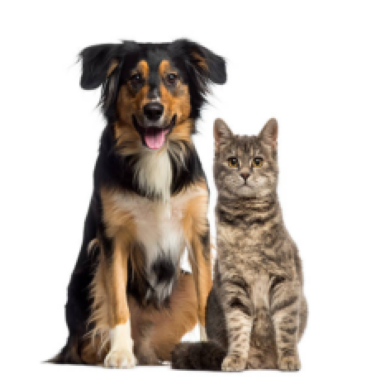

In [ ]:
# Obtain the image
image = Image.open('cat_dog.jpeg')
image = transform(image)
plot_image(image)

In [ ]:
# Loading the image
device = "cuda" if t.cuda.is_available() else "cpu"
model = model.to(device)
text_labels = ["a photo of a cat", "a photo of a dog"]
text_inputs = processor(text=text_labels, return_tensors="pt").to(device)
image_inputs = processor(images=image, return_tensors="pt")
image_inputs["pixel_values"] = image_inputs["pixel_values"].to(device)

with t.no_grad():
    outputs = model(**image_inputs, **text_inputs,output_hidden_states=True)
    image_logits = outputs.logits_per_image
    text_logits = outputs.logits_per_text
    probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()

print("Image Logits:",image_logits, "Text Logits:", text_logits, "Label probs:", probs)

Image Logits: tensor([[24.8733, 25.2194]], device='cuda:0') Text Logits: tensor([[24.8733],
        [25.2194]], device='cuda:0') Label probs: [[0.4143234  0.58567655]]


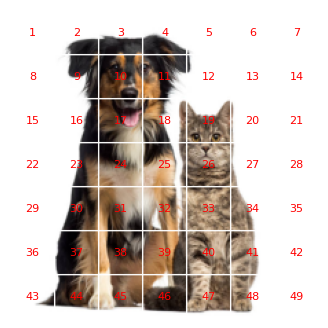

In [ ]:
from vit_prisma.visualization.visualize_image import display_grid_on_image

display_grid_on_image(image, patch_size=32)

In [ ]:
# Find cosine similarities
cosine_similarities = t.cosine_similarity(image_logits, text_logits, dim=0)
print(f"cosine similarities: {cosine_similarities}")

cosine similarities: tensor([1.0000, 1.0000], device='cuda:0')


In [ ]:
# Accumulated residual
cat_index = imagenet_index_from_word("cat")
dog_index = imagenet_index_from_word("dog")
print(f"Cat index: {cat_index}, Dog index: {dog_index}")

Cat index: 30, Dog index: 153


In [ ]:
# Finding the residual directions
# For Images (ViT/CLIP): the residual directions for a class in the column of the classification head weight matrix for that class. 
# For texts (CLIP): the residual direction for a label is the embedding for that label 
cat_image_residual_directions = model.visual_projection.weight[cat_index]
dog_image_residual_directions = model.visual_projection.weight[dog_index]
print(f"Cat residual direction: {cat_image_residual_directions.shape}")
print(f"Dog residual direction: {dog_image_residual_directions.shape}")
with t.no_grad():
   text_residual_directions = model.get_text_features(**text_inputs)
cat_text_residual_directions = text_residual_directions[0]
dog_text_residual_directions = text_residual_directions[1]
print(f"Cat text residual direction: {cat_text_residual_directions.shape}")
print(f"Dog text residual direction: {dog_text_residual_directions.shape}")   

Cat residual direction: torch.Size([768])
Dog residual direction: torch.Size([768])
Cat text residual direction: torch.Size([512])
Dog text residual direction: torch.Size([512])


In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]
print(f"Shape of the CLS token in vision model: {cls_vision_residual_stream.shape}")
print(f"Shape of the CLS token in text model: {cls_text_residual_stream.shape}")
# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    dog_text_residual_directions)
print(f"Cat vision logit: {cat_vision_logit.shape}")
print(f"Dog vision logit: {dog_vision_logit.shape}")
print(f"Cat text logit: {cat_text_logit}")
print(f"Dog text logit: {dog_text_logit}")
# Add the bias for the cat class to the vision logit
if getattr(model.visual_projection, 'bias',None) is not None:
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if getattr(model.text_projection, 'bias', None) is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Cat vision logit taken directly from the model's output:{round(image_logits[0,0].item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Dog vision logit taken directly from the model's output: {round(image_logits[0,1].item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Cat text logit taken directly from the model's output: {round(text_logits[0,0].item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")
print(f"Dog text logit taken directly from the model's output: {round(text_logits[1,0].item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([1, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([2, 7, 512])
Shape of the CLS token in vision model: torch.Size([1, 768])
Shape of the CLS token in text model: torch.Size([2, 512])
Scaled CLS Vision shape: torch.Size([1, 768])
Scaled CLS Text shape: torch.Size([2, 512])
Cat vision logit: torch.Size([1])
Dog vision logit: torch.Size([1])
Cat text logit: 5.062414646148682
Dog text logit: 2.8704676628112793
No bias in the visual projection layer.
No bias in the text projection layer.
Cat vision logit: -0.199
Cat vision logit taken directly from the model's output:24.873
Dog vision logit: -0.063
Dog vision logit taken directly from the model's output: 25.219
Cat text logit: 5.062
Cat text logit taken directly from the model's 

In [ ]:
# Get the embeddings
image_feats = outputs.image_embeds
text_feats = outputs.text_embeds
print(f"image_feats: {image_feats.shape}")
print(f"text_feats: {text_feats.shape}")

image_feats: torch.Size([1, 512])
text_feats: torch.Size([2, 512])


In [ ]:
# Cosine similarities for embeddings
cosine_similarities = t.cosine_similarity(image_feats, text_feats, dim = 1)
print(f"Cosine similarities in the embedding space: {cosine_similarities}")

Cosine similarities in the embedding space: tensor([0.2487, 0.2522], device='cuda:0')


In [ ]:
# Convert the tensor to a numpy array for plotting

import plotly.express as px
cosine_similarities_np = cosine_similarities.detach().cpu().numpy()
import plotly.io as pio
pio.renderers.default = "browser"  # or "vscode" or "notebook_connected"
fig = px.bar(
    x = text_labels,
    y = cosine_similarities_np,
    title = "Cosine Similarities between Image and Text Features",
    labels = {'x': 'Text Labels', 'y': 'Cosine Similarities'},

)
fig.show()


# similarity_range = cosine_similarities.max() - cosine_similarities.min()
similarity_range = cosine_similarities.max() - cosine_similarities.min()
if similarity_range < 0.1:
  print("Poor alignment")

Poor alignment


In [ ]:
# Get the embeddings
image_embeds = outputs.image_embeds
text_embeds = outputs.text_embeds
print(f"image_feats: {image_embeds.shape}")
print(f"text_feats: {text_embeds.shape}")

image_feats: torch.Size([1, 512])
text_feats: torch.Size([2, 512])


In [ ]:
# Cosine similarities for embeddings
cosine_similarities = t.cosine_similarity(image_embeds, text_embeds, dim = 1)
print(f"Cosine similarities in the embedding space: {cosine_similarities}")

Cosine similarities in the embedding space: tensor([0.2487, 0.2522], device='cuda:0')


In [ ]:
# Convert the tensor to a numpy array for plotting

import plotly.express as px
cosine_similarities_np = cosine_similarities.detach().cpu().numpy()
import plotly.io as pio
pio.renderers.default = "browser"  # or "vscode" or "notebook_connected"
fig = px.bar(
    x = text_labels,
    y = cosine_similarities_np,
    title = "Cosine Similarities between Image and Text Features",
    labels = {'x': 'Text Labels', 'y': 'Cosine Similarities'},

)
fig.show()


# similarity_range = cosine_similarities.max() - cosine_similarities.min()
similarity_range = cosine_similarities.max() - cosine_similarities.min()
if similarity_range < 0.1:
  print("Poor alignment")

Poor alignment


In [ ]:
# Convert the tensor to a numpy array for plotting

import plotly.express as px
cosine_similarities_np = cosine_similarities.detach().cpu().numpy()
import plotly.io as pio
pio.renderers.default = "browser"  # or "vscode" or "notebook_connected"
fig = px.bar(
    x = text_labels,
    y = cosine_similarities_np,
    title = "Cosine Similarities between Image and Text Embeddings",
    labels = {'x': 'Text Labels', 'y': 'Cosine Similarities'},

)
fig.show()


# similarity_range = cosine_similarities.max() - cosine_similarities.min()
similarity_range = cosine_similarities.max() - cosine_similarities.min()
if similarity_range < 0.1:
  print("Poor alignment")

Poor alignment


In [ ]:
# Mean ablation
def mean_ablation(
      z:Float[Tensor,'batch d_model'],
      hook: prisma_utils.Hook,
      head_index_to_ablate:int,
)-> None:
   """
   Ablate the mean of the head's output.
   """
   # Get the head's output
   head_output = hook.get_head_output(z, head_index_to_ablate)
   # Compute the mean of the head's output
   mean = head_output.mean(dim=0, keepdim=True)
   # Subtract the mean from the head's output
   z -= mean
   # Return the ablated output
   return z

NameError: name 'Float' is not defined

In [ ]:
import vit_prisma
from vit_prisma.utils.data_utils.imagenet.imagenet_dict import IMAGENET_DICT
from vit_prisma.utils import prisma_utils

#from transformers import CLIPProcessor, CLIPModel

from vit_prisma.utils.data_utils.imagenet.imagenet_utils import imagenet_index_from_word
import numpy as np
import torch as t
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from IPython.display import display, HTML
import type

ModuleNotFoundError: No module named 'type'

In [ ]:
import vit_prisma
from vit_prisma.utils.data_utils.imagenet.imagenet_dict import IMAGENET_DICT
from vit_prisma.utils import prisma_utils

#from transformers import CLIPProcessor, CLIPModel

from vit_prisma.utils.data_utils.imagenet.imagenet_utils import imagenet_index_from_word
import numpy as np
import torch as t
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from IPython.display import display, HTML
from typing import Callable

In [ ]:
# Mean ablation
def mean_ablation(
      z:Float[Tensor,'batch d_model'],
      hook: prisma_utils.Hook,
      head_index_to_ablate:int,
)-> None:
   """
   Ablate the mean of the head's output.
   """
   # Get the head's output
   head_output = hook.get_head_output(z, head_index_to_ablate)
   # Compute the mean of the head's output
   mean = head_output.mean(dim=0, keepdim=True)
   # Subtract the mean from the head's output
   z -= mean
   # Return the ablated output
   return z

NameError: name 'Float' is not defined

In [ ]:
import vit_prisma
from vit_prisma.utils.data_utils.imagenet.imagenet_dict import IMAGENET_DICT
from vit_prisma.utils import prisma_utils

#from transformers import CLIPProcessor, CLIPModel

from vit_prisma.utils.data_utils.imagenet.imagenet_utils import imagenet_index_from_word
import numpy as np
import torch as t
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from IPython.display import display, HTML
from typing import Callable
from jaxtyping import Float, Int,Tensor

ImportError: cannot import name 'Tensor' from 'jaxtyping' (c:\Users\User\anaconda3\envs\llava\lib\site-packages\jaxtyping\__init__.py)

In [ ]:
import vit_prisma
from vit_prisma.utils.data_utils.imagenet.imagenet_dict import IMAGENET_DICT
from vit_prisma.utils import prisma_utils

#from transformers import CLIPProcessor, CLIPModel

from vit_prisma.utils.data_utils.imagenet.imagenet_utils import imagenet_index_from_word
import numpy as np
import torch as t
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from IPython.display import display, HTML
from typing import Callable
from jaxtyping import Float, Int

In [ ]:
import vit_prisma
from vit_prisma.utils.data_utils.imagenet.imagenet_dict import IMAGENET_DICT
from vit_prisma.utils import prisma_utils

#from transformers import CLIPProcessor, CLIPModel

from vit_prisma.utils.data_utils.imagenet.imagenet_utils import imagenet_index_from_word
import numpy as np
import torch as t
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from IPython.display import display, HTML
from typing import Callable
from jaxtyping import Float, Int
from torch import Tensor

In [ ]:
# Mean ablation
def mean_ablation(
      z:Float[Tensor,'batch seq d_model'],
      y:Float[Tensor,'batch d_model'],
      hook: prisma_utils.Hook,
      head_index_to_ablate:int,
)-> None:
   """
   Ablate the mean of the head's output.
   """
   # Get the text head's output
   text_head_output = hook.get_head_output(z, head_index_to_ablate)
   # Compute the mean of the head's output
   text_mean = text_head_output.mean(dim=0, keepdim=True)
   # Subtract the mean from the head's output
   z -= text_mean
   # Return the ablated output
   return z
   # Get the image head's output
   image_head_output = hook.get_head_output(y, head_index_to_ablate)
    # Compute the mean of the image head's output
   image_mean = image_head_output.mean(dim=0, keepdim=True)
    # Subtract the mean from the image head's output
   y -= image_mean
   return y

AttributeError: module 'vit_prisma.utils.prisma_utils' has no attribute 'Hook'

Connected to llava (Python 3.10.16)

In [ ]:
import vit_prisma
from vit_prisma.utils.data_utils.imagenet.imagenet_dict import IMAGENET_DICT
from vit_prisma.utils import prisma_utils

#from transformers import CLIPProcessor, CLIPModel

from vit_prisma.utils.data_utils.imagenet.imagenet_utils import imagenet_index_from_word
import numpy as np
import torch as t
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from IPython.display import display, HTML
from typing import Callable
from jaxtyping import Float, Int
from torch import Tensor

In [ ]:
# Helper function (ignore)
def plot_image(image):
  plt.figure()
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))

class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

transform = transforms.Compose([
    ConvertTo3Channels(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def plot_logit_boxplot(average_logits, labels):
  hovertexts = np.array([[IMAGENET_DICT[i] for _ in range(25)] for i in range(1000)])

  fig = go.Figure()
  data = []

  # if tensor, turn to numpy
  if isinstance(average_logits, torch.Tensor):
      average_logits = average_logits.detach().cpu().numpy()

  for i in range(average_logits.shape[1]):  # For each layer
      layer_logits = average_logits[:, i]
      hovertext = hovertexts[:, i]
      box = fig.add_trace(go.Box(
          y=layer_logits,
          name=f'{layer_labels[i]}',
          text=hovertext,
          hoverinfo='y+text',
          boxpoints='suspectedoutliers'
      ))
      data.append(box)


  means = np.mean(average_logits, axis=0)
  fig.add_trace(go.Scatter(
      x = layer_labels,
      y=means,
      mode='markers',
      name='Mean',
      # line=dict(color='gray'),
      marker=dict(size=4, color='red'),
  ))


  fig.update_layout(
      title='Raw Logit Values Per Layer (each dot is 1 ImageNet Class)',
      xaxis=dict(title='Layer'),
      yaxis=dict(title='Logit Values'),
      showlegend=False
  )

  fig.show()

In [ ]:
def plot_patched_component(patched_head, title=''):
  """
  Use for plotting Activation Patching.
  """

  fig = go.Figure(data=go.Heatmap(
      z=patched_head.detach().numpy(),
      colorscale='RdBu',  # You can choose any colorscale
      colorbar=dict(title='Value'),  # Customize the color bar
      hoverongaps=False
  ))
  fig.update_layout(
      title=title,
      xaxis_title='Attention Head',
      yaxis_title='Patch Number',
  )

  return fig

def imshow(tensor, **kwargs):
    """
    Use for Activation Patching.
    """
    px.imshow(
          prisma_utils.to_numpy(tensor),
          color_continuous_midpoint=0.0,
          color_continuous_scale="RdBu",
          **kwargs,
      ).show()

In [ ]:
# We'll use a text-image transformer. Loading the model
from transformers import CLIPProcessor, CLIPModel
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
import vit_prisma
from vit_prisma.utils.data_utils.imagenet.imagenet_dict import IMAGENET_DICT
from vit_prisma.utils import prisma_utils

#from transformers import CLIPProcessor, CLIPModel

from vit_prisma.utils.data_utils.imagenet.imagenet_utils import imagenet_index_from_word
import numpy as np
import torch as t
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from IPython.display import display, HTML
from typing import Callable
from jaxtyping import Float, Int
from torch import Tensor
from torchvision import datasets, transforms

In [ ]:
import vit_prisma
from vit_prisma.utils.data_utils.imagenet.imagenet_dict import IMAGENET_DICT
from vit_prisma.utils import prisma_utils

#from transformers import CLIPProcessor, CLIPModel

from vit_prisma.utils.data_utils.imagenet.imagenet_utils import imagenet_index_from_word
import numpy as np
import torch as t
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from IPython.display import display, HTML
from typing import Callable
from jaxtyping import Float, Int
from torch import Tensor
from torchvision import datasets, transforms

In [ ]:
# Helper function (ignore)
def plot_image(image):
  plt.figure()
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))

class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

transform = transforms.Compose([
    ConvertTo3Channels(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def plot_logit_boxplot(average_logits, labels):
  hovertexts = np.array([[IMAGENET_DICT[i] for _ in range(25)] for i in range(1000)])

  fig = go.Figure()
  data = []

  # if tensor, turn to numpy
  if isinstance(average_logits, torch.Tensor):
      average_logits = average_logits.detach().cpu().numpy()

  for i in range(average_logits.shape[1]):  # For each layer
      layer_logits = average_logits[:, i]
      hovertext = hovertexts[:, i]
      box = fig.add_trace(go.Box(
          y=layer_logits,
          name=f'{layer_labels[i]}',
          text=hovertext,
          hoverinfo='y+text',
          boxpoints='suspectedoutliers'
      ))
      data.append(box)


  means = np.mean(average_logits, axis=0)
  fig.add_trace(go.Scatter(
      x = layer_labels,
      y=means,
      mode='markers',
      name='Mean',
      # line=dict(color='gray'),
      marker=dict(size=4, color='red'),
  ))


  fig.update_layout(
      title='Raw Logit Values Per Layer (each dot is 1 ImageNet Class)',
      xaxis=dict(title='Layer'),
      yaxis=dict(title='Logit Values'),
      showlegend=False
  )

  fig.show()

In [ ]:
def plot_patched_component(patched_head, title=''):
  """
  Use for plotting Activation Patching.
  """

  fig = go.Figure(data=go.Heatmap(
      z=patched_head.detach().numpy(),
      colorscale='RdBu',  # You can choose any colorscale
      colorbar=dict(title='Value'),  # Customize the color bar
      hoverongaps=False
  ))
  fig.update_layout(
      title=title,
      xaxis_title='Attention Head',
      yaxis_title='Patch Number',
  )

  return fig

def imshow(tensor, **kwargs):
    """
    Use for Activation Patching.
    """
    px.imshow(
          prisma_utils.to_numpy(tensor),
          color_continuous_midpoint=0.0,
          color_continuous_scale="RdBu",
          **kwargs,
      ).show()

In [ ]:
# We'll use a text-image transformer. Loading the model
from transformers import CLIPProcessor, CLIPModel
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
import vit_prisma
from vit_prisma.utils.data_utils.imagenet.imagenet_dict import IMAGENET_DICT
from vit_prisma.utils import prisma_utils

#from transformers import CLIPProcessor, CLIPModel

from vit_prisma.utils.data_utils.imagenet.imagenet_utils import imagenet_index_from_word
import numpy as np
import torch as t
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from IPython.display import display, HTML
from typing import Callable
from jaxtyping import Float, Int
from torch import Tensor
from torchvision import datasets, transforms
from t.utils.data import DataLoader

ModuleNotFoundError: No module named 't'

In [ ]:
import vit_prisma
from vit_prisma.utils.data_utils.imagenet.imagenet_dict import IMAGENET_DICT
from vit_prisma.utils import prisma_utils

#from transformers import CLIPProcessor, CLIPModel

from vit_prisma.utils.data_utils.imagenet.imagenet_utils import imagenet_index_from_word
import numpy as np
import torch as t
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from IPython.display import display, HTML
from typing import Callable
from jaxtyping import Float, Int
from torch import Tensor
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
# Helper function (ignore)
def plot_image(image):
  plt.figure()
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))

class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

transform = transforms.Compose([
    ConvertTo3Channels(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def plot_logit_boxplot(average_logits, labels):
  hovertexts = np.array([[IMAGENET_DICT[i] for _ in range(25)] for i in range(1000)])

  fig = go.Figure()
  data = []

  # if tensor, turn to numpy
  if isinstance(average_logits, torch.Tensor):
      average_logits = average_logits.detach().cpu().numpy()

  for i in range(average_logits.shape[1]):  # For each layer
      layer_logits = average_logits[:, i]
      hovertext = hovertexts[:, i]
      box = fig.add_trace(go.Box(
          y=layer_logits,
          name=f'{layer_labels[i]}',
          text=hovertext,
          hoverinfo='y+text',
          boxpoints='suspectedoutliers'
      ))
      data.append(box)


  means = np.mean(average_logits, axis=0)
  fig.add_trace(go.Scatter(
      x = layer_labels,
      y=means,
      mode='markers',
      name='Mean',
      # line=dict(color='gray'),
      marker=dict(size=4, color='red'),
  ))


  fig.update_layout(
      title='Raw Logit Values Per Layer (each dot is 1 ImageNet Class)',
      xaxis=dict(title='Layer'),
      yaxis=dict(title='Logit Values'),
      showlegend=False
  )

  fig.show()

In [ ]:
def plot_patched_component(patched_head, title=''):
  """
  Use for plotting Activation Patching.
  """

  fig = go.Figure(data=go.Heatmap(
      z=patched_head.detach().numpy(),
      colorscale='RdBu',  # You can choose any colorscale
      colorbar=dict(title='Value'),  # Customize the color bar
      hoverongaps=False
  ))
  fig.update_layout(
      title=title,
      xaxis_title='Attention Head',
      yaxis_title='Patch Number',
  )

  return fig

def imshow(tensor, **kwargs):
    """
    Use for Activation Patching.
    """
    px.imshow(
          prisma_utils.to_numpy(tensor),
          color_continuous_midpoint=0.0,
          color_continuous_scale="RdBu",
          **kwargs,
      ).show()

In [ ]:
# We'll use a text-image transformer. Loading the model
from transformers import CLIPProcessor, CLIPModel
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
transform = transforms.Compose([
   transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
# Download CIFAR-10 dataset
cifar_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar_loader = DataLoader(cifar_dataset, batch_size=1, shuffle=True)

# CIFAR-10 class names
cifar_labels = cifar_dataset.classes

# Get a batch of images and labels
images, labels = next(iter(cifar_loader))

# Convert tensor images to PIL images for visualization or further processing
pil_images = [transforms.ToPILImage()(img) for img in images]
text_labels = [f"a photo of a {cifar_labels[label]}" for label in labels]

100%|██████████| 170M/170M [00:52<00:00, 3.25MB/s] 


In [ ]:
# Loading the image
device = "cuda" if t.cuda.is_available() else "cpu"
model = model.to(device)

# Use the batch of images and labels generated earlier
# images: tensor of shape [batch_size, 3, 224, 224]
# text_labels: list of strings like ["a photo of a cat", "a photo of a dog", ...]

# Prepare text and image inputs for the whole batch
text_inputs = processor(text=text_labels, return_tensors="pt", padding=True).to(device)
image_inputs = processor(images=pil_images, return_tensors="pt")
image_inputs["pixel_values"] = image_inputs["pixel_values"].to(device)

with t.no_grad():
    outputs = model(**image_inputs, **text_inputs, output_hidden_states=True)
    image_logits = outputs.logits_per_image
    text_logits = outputs.logits_per_text
    probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()

print("Image Logits:", image_logits)
print("Text Logits:", text_logits)
print("Label probs:", probs)

Image Logits: tensor([[27.5395]], device='cuda:0')
Text Logits: tensor([[27.5395]], device='cuda:0')
Label probs: [[1.]]


In [ ]:
from vit_prisma.visualization.visualize_image import display_grid_on_image

display_grid_on_image(pil_images, patch_size=32)

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
from vit_prisma.visualization.visualize_image import display_grid_on_image

display_grid_on_image(images, patch_size=32)

ValueError: axes don't match array

In [ ]:
# Find cosine similarities
cosine_similarities = t.cosine_similarity(image_logits, text_logits, dim=0)
print(f"cosine similarities: {cosine_similarities}")

cosine similarities: tensor([1.], device='cuda:0')


In [ ]:
# Accumulated residual
for i,label_indx in enumerate(text_labels):
   class_name = cifar_labels[label_indx]
   print(f" Image {i} is a {class_name}, class index: {label_indx}")

TypeError: list indices must be integers or slices, not str

In [ ]:
# Accumulated residual
for i,label_indx in enumerate(text_labels):
   class_name = cifar_labels[label_indx]
   print(f" Image {i}: class name = {class_name}, class index: {label_indx}")

TypeError: list indices must be integers or slices, not str

In [ ]:
# Accumulated residual
for i,label_indx in enumerate(labels):
   class_name = cifar_labels[label_indx]
   print(f" Image {i}: class name = {class_name}, class index: {label_indx}")

 Image 0: class name = automobile, class index: 1


In [ ]:
transform = transforms.Compose([
   transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
# Download CIFAR-10 dataset
cifar_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar_loader = DataLoader(cifar_dataset, batch_size=8, shuffle=True)

# CIFAR-10 class names
cifar_labels = cifar_dataset.classes

# Get a batch of images and labels
images, labels = next(iter(cifar_loader))

# Convert tensor images to PIL images for visualization or further processing
pil_images = [transforms.ToPILImage()(img) for img in images]
text_labels = [f"a photo of a {cifar_labels[label]}" for label in labels]

In [ ]:
transform = transforms.Compose([
   transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
# Download CIFAR-10 dataset
cifar_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar_loader = DataLoader(cifar_dataset, batch_size=8, shuffle=True)

# CIFAR-10 class names
cifar_labels = cifar_dataset.classes

# Get a batch of images and labels
images, labels = next(iter(cifar_loader))

# Convert tensor images to PIL images for visualization or further processing
pil_images = [transforms.ToPILImage()(img) for img in images]
text_labels = [f"a photo of a {cifar_labels[label]}" for label in labels]

In [ ]:
# Loading the image
device = "cuda" if t.cuda.is_available() else "cpu"
model = model.to(device)

# Use the batch of images and labels generated earlier
# images: tensor of shape [batch_size, 3, 224, 224]
# text_labels: list of strings like ["a photo of a cat", "a photo of a dog", ...]

# Prepare text and image inputs for the whole batch
text_inputs = processor(text=text_labels, return_tensors="pt", padding=True).to(device)
image_inputs = processor(images=pil_images, return_tensors="pt")
image_inputs["pixel_values"] = image_inputs["pixel_values"].to(device)

with t.no_grad():
    outputs = model(**image_inputs, **text_inputs, output_hidden_states=True)
    image_logits = outputs.logits_per_image
    text_logits = outputs.logits_per_text
    probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()

print("Image Logits:", image_logits)
print("Text Logits:", text_logits)
print("Label probs:", probs)

Image Logits: tensor([[25.0470, 23.4246, 20.9031, 28.9887, 27.1641, 24.2243, 24.2243, 23.6072],
        [20.7716, 28.2530, 21.6250, 22.0323, 22.3932, 21.9408, 21.9408, 21.7595],
        [19.2352, 22.8288, 27.5244, 20.9719, 21.3108, 19.5020, 19.5020, 21.4389],
        [25.0799, 22.7408, 22.3508, 30.2263, 24.7297, 23.4332, 23.4332, 24.0252],
        [21.7990, 21.6669, 20.2751, 24.6280, 27.8051, 22.9684, 22.9684, 22.5791],
        [20.0905, 21.8069, 22.1405, 21.8154, 23.5036, 27.3558, 27.3558, 21.3270],
        [22.0514, 23.7499, 22.1836, 22.9739, 23.4399, 23.3332, 23.3332, 23.4434],
        [20.5158, 22.1391, 20.5759, 22.5891, 21.2416, 20.7643, 20.7643, 25.0974]],
       device='cuda:0')
Text Logits: tensor([[25.0470, 20.7716, 19.2352, 25.0799, 21.7990, 20.0905, 22.0514, 20.5158],
        [23.4246, 28.2530, 22.8288, 22.7408, 21.6669, 21.8069, 23.7499, 22.1391],
        [20.9031, 21.6250, 27.5244, 22.3508, 20.2751, 22.1405, 22.1836, 20.5759],
        [28.9887, 22.0323, 20.9719, 30.2263, 2

In [ ]:
# Find cosine similarities
cosine_similarities = t.cosine_similarity(image_logits, text_logits, dim=0)
print(f"cosine similarities: {cosine_similarities}")

cosine similarities: tensor([0.9979, 0.9990, 0.9975, 0.9977, 0.9970, 0.9950, 0.9954, 0.9987],
       device='cuda:0')


In [ ]:
# Finding the residual directions
# For Images (ViT/CLIP): the residual directions for a class in the column of the classification head weight matrix for that class. 
# For texts (CLIP): the residual direction for a label is the embedding for that label 
cat_image_residual_directions = model.visual_projection.weight[cat_index]
dog_image_residual_directions = model.visual_projection.weight[dog_index]
print(f"Cat residual direction: {cat_image_residual_directions.shape}")
print(f"Dog residual direction: {dog_image_residual_directions.shape}")
with t.no_grad():
   text_residual_directions = model.get_text_features(**text_inputs)
cat_text_residual_directions = text_residual_directions[0]
dog_text_residual_directions = text_residual_directions[1]
print(f"Cat text residual direction: {cat_text_residual_directions.shape}")
print(f"Dog text residual direction: {dog_text_residual_directions.shape}")   

NameError: name 'cat_index' is not defined

In [ ]:
# Accumulated residual
for i,label_indx in enumerate(labels):
   class_name = cifar_labels[label_indx]
   print(f" Image {i}: class name = {class_name}, class index: {label_indx}")

 Image 0: class name = deer, class index: 4
 Image 1: class name = automobile, class index: 1
 Image 2: class name = ship, class index: 8
 Image 3: class name = horse, class index: 7
 Image 4: class name = dog, class index: 5
 Image 5: class name = cat, class index: 3
 Image 6: class name = cat, class index: 3
 Image 7: class name = bird, class index: 2


In [ ]:
# Finding the residual directions
# For Images (ViT/CLIP): the residual directions for a class in the column of the classification head weight matrix for that class. 
# For texts (CLIP): the residual direction for a label is the embedding for that label 
image_residual_directions = model.visual_projection.weight[label_indx]
print(f"Visual residual direction: {image_residual_directions.shape}")
with t.no_grad():
   text_residual_directions = model.get_text_features(**text_inputs)
print(f"Text residual directions: {text_residual_directions.shape}") 

Visual residual direction: torch.Size([768])
Text residual directions: torch.Size([8, 512])


In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]
print(f"Shape of the CLS token in vision model: {cls_vision_residual_stream.shape}")
print(f"Shape of the CLS token in text model: {cls_text_residual_stream.shape}")
# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

cat_vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    cat_image_residual_directions)
dog_vision_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_vision,
                    dog_image_residual_directions)
cat_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    cat_text_residual_directions)
dog_text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    dog_text_residual_directions)
print(f"Cat vision logit: {cat_vision_logit.shape}")
print(f"Dog vision logit: {dog_vision_logit.shape}")
print(f"Cat text logit: {cat_text_logit}")
print(f"Dog text logit: {dog_text_logit}")
# Add the bias for the cat class to the vision logit
if getattr(model.visual_projection, 'bias',None) is not None:
    cat_vision_logit += model.visual_projection.bias[cat_index]
    dog_vision_logit += model.visual_projection.bias[dog_index]
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if getattr(model.text_projection, 'bias', None) is not None:
    cat_text_logit += model.text_projection.bias[cat_index]
    dog_text_logit += model.text_projection.bias[dog_index]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Cat vision logit: {round(cat_vision_logit.item(),3)}")
print(f"Cat vision logit taken directly from the model's output:{round(image_logits[0,0].item(),3)}")
print(f"Dog vision logit: {round(dog_vision_logit.item(),3)}")
print(f"Dog vision logit taken directly from the model's output: {round(image_logits[0,1].item(),3)}")
print(f"Cat text logit: {round(cat_text_logit.item(),3)}")
print(f"Cat text logit taken directly from the model's output: {round(text_logits[0,0].item(),3)}")
print(f"Dog text logit: {round(dog_text_logit.item(),3)}")
print(f"Dog text logit taken directly from the model's output: {round(text_logits[1,0].item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([8, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([8, 7, 512])
Shape of the CLS token in vision model: torch.Size([8, 768])
Shape of the CLS token in text model: torch.Size([8, 512])
Scaled CLS Vision shape: torch.Size([8, 768])
Scaled CLS Text shape: torch.Size([8, 512])


NameError: name 'cat_image_residual_directions' is not defined

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]
print(f"Shape of the CLS token in vision model: {cls_vision_residual_stream.shape}")
print(f"Shape of the CLS token in text model: {cls_text_residual_stream.shape}")
# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    image_residual_directions)
text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text,
                    text_residual_directions)

print(f"Vision logit: {vision_logit.shape}")
print(f"Text logit: {text_logit}")

# Add the bias for the cat class to the vision logit
if getattr(model.visual_projection, 'bias',None) is not None:
    vision_logit += model.visual_projection.bias[label_indx]
   
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if getattr(model.text_projection, 'bias', None) is not None:
    text_logit += model.text_projection.bias[label_indx]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Vision logit: {round(vision_logit.item(),3)}")

print(f"Vision logit taken directly from the model's output: {round(image_logits.item(),3)}")
print(f"Text logit: {round(text_logit.item(),3)}")
print(f"Text logit taken directly from the model's output: {round(text_logits.item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([8, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([8, 7, 512])
Shape of the CLS token in vision model: torch.Size([8, 768])
Shape of the CLS token in text model: torch.Size([8, 512])
Scaled CLS Vision shape: torch.Size([8, 768])
Scaled CLS Text shape: torch.Size([8, 512])


RuntimeError: einsum(): the number of subscripts in the equation (1) does not match the number of dimensions (2) for operand 1 and no ellipsis was given

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}") # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model

last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]

cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]
print(f"Shape of the CLS token in vision model: {cls_vision_residual_stream.shape}")
print(f"Shape of the CLS token in text model: {cls_text_residual_stream.shape}")
# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

vision_logit = einsum ('... d_model,d_model -> ...',
                    scaled_cls_vision,
                    image_residual_directions)
text_logit = einsum ('... d_model, d_model -> ...',
                    scaled_cls_text[0],
                    text_residual_directions)

print(f"Vision logit: {vision_logit.shape}")
print(f"Text logit: {text_logit}")

# Add the bias for the cat class to the vision logit
if getattr(model.visual_projection, 'bias',None) is not None:
    vision_logit += model.visual_projection.bias[label_indx]
   
else:
    print("No bias in the visual projection layer.")
# Add the bias for the cat class to the text logit
if getattr(model.text_projection, 'bias', None) is not None:
    text_logit += model.text_projection.bias[label_indx]
else:
    print("No bias in the text projection layer.")
# Print the logits
print(f"Vision logit: {round(vision_logit.item(),3)}")

print(f"Vision logit taken directly from the model's output: {round(image_logits.item(),3)}")
print(f"Text logit: {round(text_logit.item(),3)}")
print(f"Text logit taken directly from the model's output: {round(text_logits.item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([8, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([8, 7, 512])
Shape of the CLS token in vision model: torch.Size([8, 768])
Shape of the CLS token in text model: torch.Size([8, 512])
Scaled CLS Vision shape: torch.Size([8, 768])
Scaled CLS Text shape: torch.Size([8, 512])


RuntimeError: einsum(): the number of subscripts in the equation (1) does not match the number of dimensions (2) for operand 1 and no ellipsis was given

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}")  # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}")  # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model
last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]
cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]
print(f"Shape of the CLS token in vision model: {cls_vision_residual_stream.shape}")
print(f"Shape of the CLS token in text model: {cls_text_residual_stream.shape}")

# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

# Compute logits for each image-text pair in the batch
# image_residual_directions: [batch, d_model] or [d_model]
# text_residual_directions: [batch, d_model] or [d_model]
# If you want to compute the logit for each image-text pair, use einsum over the batch
vision_logit = einsum('bd,bd->b', scaled_cls_vision, image_residual_directions)
text_logit = einsum('bd,bd->b', scaled_cls_text, text_residual_directions)

print(f"Vision logit shape: {vision_logit.shape}")
print(f"Text logit shape: {text_logit.shape}")

# Add the bias for each class to the vision and text logits if present
if getattr(model.visual_projection, 'bias', None) is not None:
    vision_logit += model.visual_projection.bias[labels]
else:
    print("No bias in the visual projection layer.")

if getattr(model.text_projection, 'bias', None) is not None:
    text_logit += model.text_projection.bias[labels]
else:
    print("No bias in the text projection layer.")

# Print the logits for the batch
for i in range(len(vision_logit)):
    print(f"Image {i}: Vision logit: {round(vision_logit[i].item(),3)}, "
          f"Vision logit from model: {round(image_logits[i, i].item(),3)}, "
          f"Text logit: {round(text_logit[i].item(),3)}, "
          f"Text logit from model: {round(text_logits[i, i].item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([8, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([8, 7, 512])
Shape of the CLS token in vision model: torch.Size([8, 768])
Shape of the CLS token in text model: torch.Size([8, 512])
Scaled CLS Vision shape: torch.Size([8, 768])
Scaled CLS Text shape: torch.Size([8, 512])


RuntimeError: einsum(): the number of subscripts in the equation (1) does not match the number of dimensions (2) for operand 0 and no ellipsis was given

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}")  # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}")  # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model
last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]
cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]
print(f"Shape of the CLS token in vision model: {cls_vision_residual_stream.shape}")
print(f"Shape of the CLS token in text model: {cls_text_residual_stream.shape}")

# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

# Compute logits for each image-text pair in the batch
# image_residual_directions: [batch, d_model] or [d_model]
# text_residual_directions: [batch, d_model] or [d_model]
# If you want to compute the logit for each image-text pair, use einsum over the batch
vision_logit = einsum('bd,d->b', scaled_cls_vision, image_residual_directions)
text_logit = einsum('bd,bd->b', scaled_cls_text, text_residual_directions)

print(f"Vision logit shape: {vision_logit.shape}")
print(f"Text logit shape: {text_logit.shape}")

# Add the bias for each class to the vision and text logits if present
if getattr(model.visual_projection, 'bias', None) is not None:
    vision_logit += model.visual_projection.bias[labels]
else:
    print("No bias in the visual projection layer.")

if getattr(model.text_projection, 'bias', None) is not None:
    text_logit += model.text_projection.bias[labels]
else:
    print("No bias in the text projection layer.")

# Print the logits for the batch
for i in range(len(vision_logit)):
    print(f"Image {i}: Vision logit: {round(vision_logit[i].item(),3)}, "
          f"Vision logit from model: {round(image_logits[i, i].item(),3)}, "
          f"Text logit: {round(text_logit[i].item(),3)}, "
          f"Text logit from model: {round(text_logits[i, i].item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([8, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([8, 7, 512])
Shape of the CLS token in vision model: torch.Size([8, 768])
Shape of the CLS token in text model: torch.Size([8, 512])
Scaled CLS Vision shape: torch.Size([8, 768])
Scaled CLS Text shape: torch.Size([8, 512])


RuntimeError: einsum(): the number of subscripts in the equation (1) does not match the number of dimensions (2) for operand 0 and no ellipsis was given

In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}")  # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}")  # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model
last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]
cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]
print(f"Shape of the CLS token in vision model: {cls_vision_residual_stream.shape}")
print(f"Shape of the CLS token in text model: {cls_text_residual_stream.shape}")

# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

# Compute logits for each image-text pair in the batch
# image_residual_directions: [batch, d_model] or [d_model]
# text_residual_directions: [batch, d_model] or [d_model]
# If you want to compute the logit for each image-text pair, use einsum over the batch
vision_logit = einsum('b d,d->b', scaled_cls_vision, image_residual_directions)
text_logit = einsum('b d,b d->b', scaled_cls_text, text_residual_directions)

print(f"Vision logit shape: {vision_logit.shape}")
print(f"Text logit shape: {text_logit.shape}")

# Add the bias for each class to the vision and text logits if present
if getattr(model.visual_projection, 'bias', None) is not None:
    vision_logit += model.visual_projection.bias[labels]
else:
    print("No bias in the visual projection layer.")

if getattr(model.text_projection, 'bias', None) is not None:
    text_logit += model.text_projection.bias[labels]
else:
    print("No bias in the text projection layer.")

# Print the logits for the batch
for i in range(len(vision_logit)):
    print(f"Image {i}: Vision logit: {round(vision_logit[i].item(),3)}, "
          f"Vision logit from model: {round(image_logits[i, i].item(),3)}, "
          f"Text logit: {round(text_logit[i].item(),3)}, "
          f"Text logit from model: {round(text_logits[i, i].item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([8, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([8, 7, 512])
Shape of the CLS token in vision model: torch.Size([8, 768])
Shape of the CLS token in text model: torch.Size([8, 512])
Scaled CLS Vision shape: torch.Size([8, 768])
Scaled CLS Text shape: torch.Size([8, 512])
Vision logit shape: torch.Size([8])
Text logit shape: torch.Size([8])
No bias in the visual projection layer.
No bias in the text projection layer.
Image 0: Vision logit: -0.019, Vision logit from model: 25.047, Text logit: 5.636, Text logit from model: 25.047
Image 1: Vision logit: -0.358, Vision logit from model: 28.253, Text logit: 6.216, Text logit from model: 28.253
Image 2: Vision logit: -0.062, Vision logit from model: 27.524, Text logit: 3.063, Text

In [ ]:
# Get the embeddings
image_embeds = outputs.image_embeds
text_embeds = outputs.text_embeds
print(f"image_feats: {image_embeds.shape}")
print(f"text_feats: {text_embeds.shape}")

image_feats: torch.Size([8, 512])
text_feats: torch.Size([8, 512])


In [ ]:
# Cosine similarities for embeddings
cosine_similarities = t.cosine_similarity(image_embeds, text_embeds, dim = 1)
print(f"Cosine similarities in the embedding space: {cosine_similarities}")

Cosine similarities in the embedding space: tensor([0.2505, 0.2825, 0.2752, 0.3023, 0.2781, 0.2736, 0.2333, 0.2510],
       device='cuda:0')


In [ ]:
# Convert the tensor to a numpy array for plotting

import plotly.express as px
cosine_similarities_np = cosine_similarities.detach().cpu().numpy()
import plotly.io as pio
pio.renderers.default = "browser"  # or "vscode" or "notebook_connected"
fig = px.bar(
    x = text_labels,
    y = cosine_similarities_np,
    title = "Cosine Similarities between Image and Text Embeddings",
    labels = {'x': 'Text Labels', 'y': 'Cosine Similarities'},

)
fig.show()


# similarity_range = cosine_similarities.max() - cosine_similarities.min()
similarity_range = cosine_similarities.max() - cosine_similarities.min()
if similarity_range < 0.1:
  print("Poor alignment")

Poor alignment


In [ ]:
# Convert the tensor to a numpy array for plotting

import plotly.express as px
cosine_similarities_np = cosine_similarities.detach().cpu().numpy()
import plotly.io as pio
pio.renderers.default = "browser"  # or "vscode" or "notebook_connected"
fig = px.bar(
    x = text_labels,
    y = cosine_similarities_np,
    title = "Cosine Similarities between Image and Text Embeddings",
    labels = {'x': 'Text Labels', 'y': 'Cosine Similarities'},

)
fig.show()


# similarity_range = cosine_similarities.max() - cosine_similarities.min()
similarity_range = cosine_similarities.max() - cosine_similarities.min()
if similarity_range < 0.1:
  print("Poor alignment")

Poor alignment


In [ ]:
# Convert the tensor to a numpy array for plotting

import plotly.express as px
cosine_similarities_np = cosine_similarities.detach().cpu().numpy()
import plotly.io as pio
pio.renderers.default = "browser"  # or "vscode" or "notebook_connected"

# Make text_labels unique by appending the image index
unique_text_labels = [f"{label} ({i})" for i, label in enumerate(text_labels)]

fig = px.bar(
    x = unique_text_labels,
    y = cosine_similarities_np,
    title = "Cosine Similarities between Image and Text Embeddings",
    labels = {'x': 'Text Labels', 'y': 'Cosine Similarities'},
)
fig.show()


# similarity_range = cosine_similarities.max() - cosine_similarities.min()
similarity_range = cosine_similarities.max() - cosine_similarities.min()
if similarity_range < 0.1:
  print("Poor alignment")

Poor alignment


In [ ]:
transform = transforms.Compose([
   transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
# Download CIFAR-10 dataset
cifar_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar_loader = DataLoader(cifar_dataset, batch_size=8, shuffle=True)
cifar_loader = DataLoader(cifar_dataset, batch_size=8, shuffle=True)

num_batches = 5  # Set how many batches you want to process
for batch_idx, (images, labels) in enumerate(cifar_loader):
    cifar_labels = cifar_dataset.classes
    images, labels = next(iter(cifar_loader))
    pil_images = [transforms.ToPILImage()(img) for img in images]
    text_labels = [f"a photo of a {cifar_labels[label]}" for label in labels]

    if batch_idx + 1 >= num_batches:
        break
# CIFAR-10 class names
#cifar_labels = cifar_dataset.classes

# Get a batch of images and labels
#images, labels = next(iter(cifar_loader))

# Convert tensor images to PIL images for visualization or further processing
#pil_images = [transforms.ToPILImage()(img) for img in images]
#text_labels = [f"a photo of a {cifar_labels[label]}" for label in labels]

In [ ]:
# Loading the image
device = "cuda" if t.cuda.is_available() else "cpu"
model = model.to(device)

# Use the batch of images and labels generated earlier
# images: tensor of shape [batch_size, 3, 224, 224]
# text_labels: list of strings like ["a photo of a cat", "a photo of a dog", ...]

# Prepare text and image inputs for the whole batch
text_inputs = processor(text=text_labels, return_tensors="pt", padding=True).to(device)
image_inputs = processor(images=pil_images, return_tensors="pt")
image_inputs["pixel_values"] = image_inputs["pixel_values"].to(device)

with t.no_grad():
    outputs = model(**image_inputs, **text_inputs, output_hidden_states=True)
    image_logits = outputs.logits_per_image
    text_logits = outputs.logits_per_text
    probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()

print("Image Logits:", image_logits)
print("Text Logits:", text_logits)
print("Label probs:", probs)

Image Logits: tensor([[29.4101, 22.0707, 22.0707, 29.4101, 24.2450, 25.1932, 24.2450, 21.7246],
        [22.0946, 26.6861, 26.6861, 22.0946, 24.4448, 24.9630, 24.4448, 24.6616],
        [22.5121, 27.3892, 27.3892, 22.5121, 22.3887, 23.2170, 22.3887, 21.4165],
        [30.2152, 24.1151, 24.1151, 30.2152, 22.2275, 23.6186, 22.2275, 21.6207],
        [24.6064, 22.8249, 22.8249, 24.6064, 27.2363, 24.9986, 27.2363, 21.1689],
        [25.6840, 25.8163, 25.8163, 25.6840, 27.5598, 29.0598, 27.5598, 23.1342],
        [28.1241, 24.3714, 24.3714, 28.1241, 26.9896, 24.8797, 26.9896, 21.2715],
        [19.9602, 22.4755, 22.4755, 19.9602, 21.9496, 22.3868, 21.9496, 26.9034]],
       device='cuda:0')
Text Logits: tensor([[29.4101, 22.0946, 22.5121, 30.2152, 24.6064, 25.6840, 28.1241, 19.9602],
        [22.0707, 26.6861, 27.3892, 24.1151, 22.8249, 25.8163, 24.3714, 22.4755],
        [22.0707, 26.6861, 27.3892, 24.1151, 22.8249, 25.8163, 24.3714, 22.4755],
        [29.4101, 22.0946, 22.5121, 30.2152, 2

In [ ]:
# Find cosine similarities
cosine_similarities = t.cosine_similarity(image_logits, text_logits, dim=0)
print(f"cosine similarities: {cosine_similarities}")

cosine similarities: tensor([0.9984, 0.9987, 0.9989, 0.9949, 0.9984, 0.9992, 0.9948, 0.9986],
       device='cuda:0')


In [ ]:
transform = transforms.Compose([
   transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
# Download CIFAR-10 dataset
cifar_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar_loader = DataLoader(cifar_dataset, batch_size=8, shuffle=True)
cifar_loader = DataLoader(cifar_dataset, batch_size=8, shuffle=True)

num_batches = 30 # Set how many batches you want to process
for batch_idx, (images, labels) in enumerate(cifar_loader):
    cifar_labels = cifar_dataset.classes
    images, labels = next(iter(cifar_loader))
    pil_images = [transforms.ToPILImage()(img) for img in images]
    text_labels = [f"a photo of a {cifar_labels[label]}" for label in labels]

    if batch_idx + 1 >= num_batches:
        break
# CIFAR-10 class names
#cifar_labels = cifar_dataset.classes

# Get a batch of images and labels
#images, labels = next(iter(cifar_loader))

# Convert tensor images to PIL images for visualization or further processing
#pil_images = [transforms.ToPILImage()(img) for img in images]
#text_labels = [f"a photo of a {cifar_labels[label]}" for label in labels]

In [ ]:
# Loading the image
device = "cuda" if t.cuda.is_available() else "cpu"
model = model.to(device)

# Use the batch of images and labels generated earlier
# images: tensor of shape [batch_size, 3, 224, 224]
# text_labels: list of strings like ["a photo of a cat", "a photo of a dog", ...]

# Prepare text and image inputs for the whole batch
text_inputs = processor(text=text_labels, return_tensors="pt", padding=True).to(device)
image_inputs = processor(images=pil_images, return_tensors="pt")
image_inputs["pixel_values"] = image_inputs["pixel_values"].to(device)

with t.no_grad():
    outputs = model(**image_inputs, **text_inputs, output_hidden_states=True)
    image_logits = outputs.logits_per_image
    text_logits = outputs.logits_per_text
    probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()

print("Image Logits:", image_logits)
print("Text Logits:", text_logits)
print("Label probs:", probs)

Image Logits: tensor([[30.4852, 30.4852, 25.7005, 23.0769, 21.7856, 23.9754, 21.7856, 23.9754],
        [27.2058, 27.2058, 24.4395, 22.4188, 20.7503, 22.4818, 20.7503, 22.4818],
        [23.5936, 23.5936, 28.7144, 22.4270, 21.4238, 22.4832, 21.4238, 22.4832],
        [21.4186, 21.4186, 22.7984, 27.3792, 22.3275, 22.3066, 22.3275, 22.3066],
        [21.9937, 21.9937, 23.0710, 22.5303, 29.7452, 25.6434, 29.7452, 25.6434],
        [23.8998, 23.8998, 25.4184, 23.2081, 23.0366, 29.9399, 23.0366, 29.9399],
        [21.7643, 21.7643, 22.4026, 23.0234, 29.8869, 27.3488, 29.8869, 27.3488],
        [22.5098, 22.5098, 22.9461, 20.8332, 22.2612, 29.9752, 22.2612, 29.9752]],
       device='cuda:0')
Text Logits: tensor([[30.4852, 27.2058, 23.5936, 21.4186, 21.9937, 23.8998, 21.7643, 22.5098],
        [30.4852, 27.2058, 23.5936, 21.4186, 21.9937, 23.8998, 21.7643, 22.5098],
        [25.7005, 24.4395, 28.7144, 22.7984, 23.0710, 25.4184, 22.4026, 22.9461],
        [23.0769, 22.4188, 22.4270, 27.3792, 2

In [ ]:
# Find cosine similarities
cosine_similarities = t.cosine_similarity(image_logits, text_logits, dim=0)
print(f"cosine similarities: {cosine_similarities}")

cosine similarities: tensor([0.9989, 0.9986, 0.9992, 0.9992, 0.9986, 0.9965, 0.9971, 0.9972],
       device='cuda:0')


In [ ]:
# Accumulated residual
for i,label_indx in enumerate(labels):
   class_name = cifar_labels[label_indx]
   print(f" Image {i}: class name = {class_name}, class index: {label_indx}")

 Image 0: class name = deer, class index: 4
 Image 1: class name = deer, class index: 4
 Image 2: class name = dog, class index: 5
 Image 3: class name = truck, class index: 9
 Image 4: class name = airplane, class index: 0
 Image 5: class name = bird, class index: 2
 Image 6: class name = airplane, class index: 0
 Image 7: class name = bird, class index: 2


In [ ]:
transform = transforms.Compose([
   transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
# Download CIFAR-10 dataset
cifar_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar_loader = DataLoader(cifar_dataset, batch_size=8, shuffle=True)
num_batches = 30  # Set how many batches you want to process
cifar_labels = cifar_dataset.classes  # Get class names once

for batch_idx, (images, labels) in enumerate(cifar_loader):
    pil_images = [transforms.ToPILImage()(img) for img in images]
    text_labels = [f"a photo of a {cifar_labels[label]}" for label in labels]

    if batch_idx + 1 >= num_batches:
        break
# CIFAR-10 class names
#cifar_labels = cifar_dataset.classes

# Get a batch of images and labels
#images, labels = next(iter(cifar_loader))

# Convert tensor images to PIL images for visualization or further processing
#pil_images = [transforms.ToPILImage()(img) for img in images]
#text_labels = [f"a photo of a {cifar_labels[label]}" for label in labels]

In [ ]:
# Loading the image
device = "cuda" if t.cuda.is_available() else "cpu"
model = model.to(device)

# Use the batch of images and labels generated earlier
# images: tensor of shape [batch_size, 3, 224, 224]
# text_labels: list of strings like ["a photo of a cat", "a photo of a dog", ...]

# Prepare text and image inputs for the whole batch
text_inputs = processor(text=text_labels, return_tensors="pt", padding=True).to(device)
image_inputs = processor(images=pil_images, return_tensors="pt")
image_inputs["pixel_values"] = image_inputs["pixel_values"].to(device)

with t.no_grad():
    outputs = model(**image_inputs, **text_inputs, output_hidden_states=True)
    image_logits = outputs.logits_per_image
    text_logits = outputs.logits_per_text
    probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()

print("Image Logits:", image_logits)
print("Text Logits:", text_logits)
print("Label probs:", probs)

Image Logits: tensor([[28.0605, 25.6656, 25.6656, 28.0605, 22.4558, 20.4003, 20.3537, 23.0350],
        [22.7953, 27.3717, 27.3717, 22.7953, 20.4459, 19.8073, 20.8912, 20.3121],
        [25.0363, 27.9401, 27.9401, 25.0363, 21.9976, 22.1441, 22.2928, 24.3088],
        [28.6162, 26.1986, 26.1986, 28.6162, 23.2514, 20.6380, 21.7892, 22.9286],
        [22.5957, 23.2123, 23.2123, 22.5957, 27.3457, 18.5817, 20.8143, 18.9490],
        [21.2862, 20.8894, 20.8894, 21.2862, 24.1546, 23.7327, 22.4763, 20.8177],
        [21.3005, 21.5558, 21.5558, 21.3005, 22.3336, 22.8055, 27.5585, 21.3465],
        [20.4213, 20.8007, 20.8007, 20.4213, 20.5429, 18.7073, 20.2959, 28.6381]],
       device='cuda:0')
Text Logits: tensor([[28.0605, 22.7953, 25.0363, 28.6162, 22.5957, 21.2862, 21.3005, 20.4213],
        [25.6656, 27.3717, 27.9401, 26.1986, 23.2123, 20.8894, 21.5558, 20.8007],
        [25.6656, 27.3717, 27.9401, 26.1986, 23.2123, 20.8894, 21.5558, 20.8007],
        [28.0605, 22.7953, 25.0363, 28.6162, 2

In [ ]:
# Find cosine similarities
cosine_similarities = t.cosine_similarity(image_logits, text_logits, dim=0)
print(f"cosine similarities: {cosine_similarities}")

cosine similarities: tensor([0.9983, 0.9986, 0.9982, 0.9987, 0.9948, 0.9958, 0.9994, 0.9972],
       device='cuda:0')


In [ ]:
# Accumulated residual
for i,label_indx in enumerate(labels):
   class_name = cifar_labels[label_indx]
   print(f" Image {i}: class name = {class_name}, class index: {label_indx}")

 Image 0: class name = truck, class index: 9
 Image 1: class name = automobile, class index: 1
 Image 2: class name = automobile, class index: 1
 Image 3: class name = truck, class index: 9
 Image 4: class name = horse, class index: 7
 Image 5: class name = frog, class index: 6
 Image 6: class name = cat, class index: 3
 Image 7: class name = ship, class index: 8


In [ ]:
# Finding the residual directions
# For Images (ViT/CLIP): the residual directions for a class in the column of the classification head weight matrix for that class. 
# For texts (CLIP): the residual direction for a label is the embedding for that label 
image_residual_directions = model.visual_projection.weight[label_indx]
print(f"Visual residual direction: {image_residual_directions.shape}")
with t.no_grad():
   text_residual_directions = model.get_text_features(**text_inputs)
print(f"Text residual directions: {text_residual_directions.shape}") 

Visual residual direction: torch.Size([768])
Text residual directions: torch.Size([8, 512])


In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}")  # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}")  # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model
last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]
cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]
print(f"Shape of the CLS token in vision model: {cls_vision_residual_stream.shape}")
print(f"Shape of the CLS token in text model: {cls_text_residual_stream.shape}")

# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

# Compute logits for each image-text pair in the batch
# image_residual_directions: [batch, d_model] or [d_model]
# text_residual_directions: [batch, d_model] or [d_model]
# If you want to compute the logit for each image-text pair, use einsum over the batch
vision_logit = einsum('b d,d->b', scaled_cls_vision, image_residual_directions)
text_logit = einsum('b d,b d->b', scaled_cls_text, text_residual_directions)

print(f"Vision logit shape: {vision_logit.shape}")
print(f"Text logit shape: {text_logit.shape}")

# Add the bias for each class to the vision and text logits if present
if getattr(model.visual_projection, 'bias', None) is not None:
    vision_logit += model.visual_projection.bias[labels]
else:
    print("No bias in the visual projection layer.")

if getattr(model.text_projection, 'bias', None) is not None:
    text_logit += model.text_projection.bias[labels]
else:
    print("No bias in the text projection layer.")

# Print the logits for the batch
for i in range(len(vision_logit)):
    print(f"Image {i}: Vision logit: {round(vision_logit[i].item(),3)}, "
          f"Vision logit from model: {round(image_logits[i, i].item(),3)}, "
          f"Text logit: {round(text_logit[i].item(),3)}, "
          f"Text logit from model: {round(text_logits[i, i].item(),3)}")


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([8, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([8, 7, 512])
Shape of the CLS token in vision model: torch.Size([8, 768])
Shape of the CLS token in text model: torch.Size([8, 512])
Scaled CLS Vision shape: torch.Size([8, 768])
Scaled CLS Text shape: torch.Size([8, 512])
Vision logit shape: torch.Size([8])
Text logit shape: torch.Size([8])
No bias in the visual projection layer.
No bias in the text projection layer.
Image 0: Vision logit: -0.093, Vision logit from model: 28.06, Text logit: -2.477, Text logit from model: 28.06
Image 1: Vision logit: 0.455, Vision logit from model: 27.372, Text logit: 6.216, Text logit from model: 27.372
Image 2: Vision logit: 0.84, Vision logit from model: 27.94, Text logit: 6.216, Text logi

In [ ]:
# Get the embeddings
image_embeds = outputs.image_embeds
text_embeds = outputs.text_embeds
print(f"image_feats: {image_embeds.shape}")
print(f"text_feats: {text_embeds.shape}")

image_feats: torch.Size([8, 512])
text_feats: torch.Size([8, 512])


In [ ]:
# Get the embeddings
image_embeds = outputs.image_embeds
text_embeds = outputs.text_embeds
print(f"Image Embeddings: {image_embeds.shape}")
print(f"Text Embeddings: {text_embeds.shape}")

Image Embeddings: torch.Size([8, 512])
Text Embeddings: torch.Size([8, 512])


In [ ]:
# Cosine similarities for embeddings
cosine_similarities = t.cosine_similarity(image_embeds, text_embeds, dim = 1)
print(f"Cosine similarities in the embedding space: {cosine_similarities}")

Cosine similarities in the embedding space: tensor([0.2806, 0.2737, 0.2794, 0.2862, 0.2735, 0.2373, 0.2756, 0.2864],
       device='cuda:0')


In [ ]:
# Convert the tensor to a numpy array for plotting

import plotly.express as px
cosine_similarities_np = cosine_similarities.detach().cpu().numpy()
import plotly.io as pio
pio.renderers.default = "browser"  # or "vscode" or "notebook_connected"

# Make text_labels unique by appending the image index
unique_text_labels = [f"{label} ({i})" for i, label in enumerate(text_labels)]

fig = px.bar(
    x = unique_text_labels,
    y = cosine_similarities_np,
    title = "Cosine Similarities between Image and Text Embeddings",
    labels = {'x': 'Text Labels', 'y': 'Cosine Similarities'},
)
fig.show()


# similarity_range = cosine_similarities.max() - cosine_similarities.min()
similarity_range = cosine_similarities.max() - cosine_similarities.min()
if similarity_range < 0.1:
  print("Poor alignment")

Poor alignment


In [ ]:
# Find cosine similarities
cosine_similarities = t.cosine_similarity(image_logits, text_logits, dim=0)
print(f"cosine similarities: {cosine_similarities}")
# Make text_labels unique by appending the image index
unique_text_labels = [f"{label} ({i})" for i, label in enumerate(text_labels)]
fig = px.bar(
    x = unique_text_labels,
    y = cosine_similarities.detach().cpu().numpy(),
    title = "Cosine Similarities between Image and Text Logits",
    labels = {'x': 'Text Labels', 'y': 'Cosine Similarities'},
)
fig.show()

cosine similarities: tensor([0.9983, 0.9986, 0.9982, 0.9987, 0.9948, 0.9958, 0.9994, 0.9972],
       device='cuda:0')


In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}")  # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}")  # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model
last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]
cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]
print(f"Shape of the CLS token in vision model: {cls_vision_residual_stream.shape}")
print(f"Shape of the CLS token in text model: {cls_text_residual_stream.shape}")

# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

# Compute logits for each image-text pair in the batch
# image_residual_directions: [batch, d_model] or [d_model]
# text_residual_directions: [batch, d_model] or [d_model]
# If you want to compute the logit for each image-text pair, use einsum over the batch
vision_logit = einsum('b d,d->b', scaled_cls_vision, image_residual_directions)
text_logit = einsum('b d,b d->b', scaled_cls_text, text_residual_directions)

print(f"Vision logit shape: {vision_logit.shape}")
print(f"Text logit shape: {text_logit.shape}")

# Add the bias for each class to the vision and text logits if present
if getattr(model.visual_projection, 'bias', None) is not None:
    vision_logit += model.visual_projection.bias[labels]
else:
    print("No bias in the visual projection layer.")

if getattr(model.text_projection, 'bias', None) is not None:
    text_logit += model.text_projection.bias[labels]
else:
    print("No bias in the text projection layer.")

# Print the logits for the batch
for i in range(len(vision_logit)):
    print(f"Image {i}: Vision logit: {round(vision_logit[i].item(),3)}, "
          f"Vision logit from model: {round(image_logits[i, i].item(),3)}, "
          f"Text logit: {round(text_logit[i].item(),3)}, "
          f"Text logit from model: {round(text_logits[i, i].item(),3)}")
    
import plotly.graph_objs as go

# Prepare unique labels for each image
unique_labels = [f"{label} ({i})" for i, label in enumerate(text_labels)]

# Convert logits to numpy for plotting
vision_logit_np = vision_logit.detach().cpu().numpy()
text_logit_np = text_logit.detach().cpu().numpy()

# Create a grouped bar chart for direct logit attributions
fig = go.Figure(data=[
    go.Bar(name='Vision Logit', x=unique_labels, y=vision_logit_np),
    go.Bar(name='Text Logit', x=unique_labels, y=text_logit_np)
])

fig.update_layout(
    barmode='group',
    title='Direct Logit Attributions per Image',
    xaxis_title='Text Labels (Image Index)',
    yaxis_title='Logit Value'
)

fig.show()


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([8, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([8, 7, 512])
Shape of the CLS token in vision model: torch.Size([8, 768])
Shape of the CLS token in text model: torch.Size([8, 512])
Scaled CLS Vision shape: torch.Size([8, 768])
Scaled CLS Text shape: torch.Size([8, 512])
Vision logit shape: torch.Size([8])
Text logit shape: torch.Size([8])
No bias in the visual projection layer.
No bias in the text projection layer.
Image 0: Vision logit: -0.093, Vision logit from model: 28.06, Text logit: -2.477, Text logit from model: 28.06
Image 1: Vision logit: 0.455, Vision logit from model: 27.372, Text logit: 6.216, Text logit from model: 27.372
Image 2: Vision logit: 0.84, Vision logit from model: 27.94, Text logit: 6.216, Text logi

Connected to llava (Python 3.10.16)

In [ ]:
# Helper function (ignore)
def plot_image(image):
  plt.figure()
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))

class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

transform = transforms.Compose([
    ConvertTo3Channels(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def plot_logit_boxplot(average_logits, labels):
  hovertexts = np.array([[IMAGENET_DICT[i] for _ in range(25)] for i in range(1000)])

  fig = go.Figure()
  data = []

  # if tensor, turn to numpy
  if isinstance(average_logits, torch.Tensor):
      average_logits = average_logits.detach().cpu().numpy()

  for i in range(average_logits.shape[1]):  # For each layer
      layer_logits = average_logits[:, i]
      hovertext = hovertexts[:, i]
      box = fig.add_trace(go.Box(
          y=layer_logits,
          name=f'{layer_labels[i]}',
          text=hovertext,
          hoverinfo='y+text',
          boxpoints='suspectedoutliers'
      ))
      data.append(box)


  means = np.mean(average_logits, axis=0)
  fig.add_trace(go.Scatter(
      x = layer_labels,
      y=means,
      mode='markers',
      name='Mean',
      # line=dict(color='gray'),
      marker=dict(size=4, color='red'),
  ))


  fig.update_layout(
      title='Raw Logit Values Per Layer (each dot is 1 ImageNet Class)',
      xaxis=dict(title='Layer'),
      yaxis=dict(title='Logit Values'),
      showlegend=False
  )

  fig.show()

NameError: name 'transforms' is not defined

In [ ]:
def plot_patched_component(patched_head, title=''):
  """
  Use for plotting Activation Patching.
  """

  fig = go.Figure(data=go.Heatmap(
      z=patched_head.detach().numpy(),
      colorscale='RdBu',  # You can choose any colorscale
      colorbar=dict(title='Value'),  # Customize the color bar
      hoverongaps=False
  ))
  fig.update_layout(
      title=title,
      xaxis_title='Attention Head',
      yaxis_title='Patch Number',
  )

  return fig

def imshow(tensor, **kwargs):
    """
    Use for Activation Patching.
    """
    px.imshow(
          prisma_utils.to_numpy(tensor),
          color_continuous_midpoint=0.0,
          color_continuous_scale="RdBu",
          **kwargs,
      ).show()

In [ ]:
# We'll use a text-image transformer. Loading the model
from transformers import CLIPProcessor, CLIPModel
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
transform = transforms.Compose([
   transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
# Download CIFAR-10 dataset
cifar_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar_loader = DataLoader(cifar_dataset, batch_size=8, shuffle=True)
num_batches = 30  # Set how many batches you want to process
cifar_labels = cifar_dataset.classes  # Get class names once

for batch_idx, (images, labels) in enumerate(cifar_loader):
    pil_images = [transforms.ToPILImage()(img) for img in images]
    text_labels = [f"a photo of a {cifar_labels[label]}" for label in labels]

    if batch_idx + 1 >= num_batches:
        break
# CIFAR-10 class names
#cifar_labels = cifar_dataset.classes

# Get a batch of images and labels
#images, labels = next(iter(cifar_loader))

# Convert tensor images to PIL images for visualization or further processing
#pil_images = [transforms.ToPILImage()(img) for img in images]
#text_labels = [f"a photo of a {cifar_labels[label]}" for label in labels]

NameError: name 'transforms' is not defined

In [ ]:
import vit_prisma
from vit_prisma.utils.data_utils.imagenet.imagenet_dict import IMAGENET_DICT
from vit_prisma.utils import prisma_utils

#from transformers import CLIPProcessor, CLIPModel

from vit_prisma.utils.data_utils.imagenet.imagenet_utils import imagenet_index_from_word
import numpy as np
import torch as t
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from IPython.display import display, HTML
from typing import Callable
from jaxtyping import Float, Int
from torch import Tensor
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
# Helper function (ignore)
def plot_image(image):
  plt.figure()
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))

class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

transform = transforms.Compose([
    ConvertTo3Channels(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def plot_logit_boxplot(average_logits, labels):
  hovertexts = np.array([[IMAGENET_DICT[i] for _ in range(25)] for i in range(1000)])

  fig = go.Figure()
  data = []

  # if tensor, turn to numpy
  if isinstance(average_logits, torch.Tensor):
      average_logits = average_logits.detach().cpu().numpy()

  for i in range(average_logits.shape[1]):  # For each layer
      layer_logits = average_logits[:, i]
      hovertext = hovertexts[:, i]
      box = fig.add_trace(go.Box(
          y=layer_logits,
          name=f'{layer_labels[i]}',
          text=hovertext,
          hoverinfo='y+text',
          boxpoints='suspectedoutliers'
      ))
      data.append(box)


  means = np.mean(average_logits, axis=0)
  fig.add_trace(go.Scatter(
      x = layer_labels,
      y=means,
      mode='markers',
      name='Mean',
      # line=dict(color='gray'),
      marker=dict(size=4, color='red'),
  ))


  fig.update_layout(
      title='Raw Logit Values Per Layer (each dot is 1 ImageNet Class)',
      xaxis=dict(title='Layer'),
      yaxis=dict(title='Logit Values'),
      showlegend=False
  )

  fig.show()

In [ ]:
def plot_patched_component(patched_head, title=''):
  """
  Use for plotting Activation Patching.
  """

  fig = go.Figure(data=go.Heatmap(
      z=patched_head.detach().numpy(),
      colorscale='RdBu',  # You can choose any colorscale
      colorbar=dict(title='Value'),  # Customize the color bar
      hoverongaps=False
  ))
  fig.update_layout(
      title=title,
      xaxis_title='Attention Head',
      yaxis_title='Patch Number',
  )

  return fig

def imshow(tensor, **kwargs):
    """
    Use for Activation Patching.
    """
    px.imshow(
          prisma_utils.to_numpy(tensor),
          color_continuous_midpoint=0.0,
          color_continuous_scale="RdBu",
          **kwargs,
      ).show()

In [ ]:
# We'll use a text-image transformer. Loading the model
from transformers import CLIPProcessor, CLIPModel
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
transform = transforms.Compose([
   transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
# Download CIFAR-10 dataset
cifar_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar_loader = DataLoader(cifar_dataset, batch_size=8, shuffle=True)
num_batches = 30  # Set how many batches you want to process
cifar_labels = cifar_dataset.classes  # Get class names once

for batch_idx, (images, labels) in enumerate(cifar_loader):
    pil_images = [transforms.ToPILImage()(img) for img in images]
    text_labels = [f"a photo of a {cifar_labels[label]}" for label in labels]

    if batch_idx + 1 >= num_batches:
        break
# CIFAR-10 class names
#cifar_labels = cifar_dataset.classes

# Get a batch of images and labels
#images, labels = next(iter(cifar_loader))

# Convert tensor images to PIL images for visualization or further processing
#pil_images = [transforms.ToPILImage()(img) for img in images]
#text_labels = [f"a photo of a {cifar_labels[label]}" for label in labels]

In [ ]:
# Loading the image
device = "cuda" if t.cuda.is_available() else "cpu"
model = model.to(device)

# Use the batch of images and labels generated earlier
# images: tensor of shape [batch_size, 3, 224, 224]


# Prepare text and image inputs for the whole batch
text_inputs = processor(text=text_labels, return_tensors="pt", padding=True).to(device)
image_inputs = processor(images=pil_images, return_tensors="pt")
image_inputs["pixel_values"] = image_inputs["pixel_values"].to(device)

with t.no_grad():
    outputs = model(**image_inputs, **text_inputs, output_hidden_states=True)
    image_logits = outputs.logits_per_image
    text_logits = outputs.logits_per_text
    probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()

print("Image Logits:", image_logits)
print("Text Logits:", text_logits)
print("Label probs:", probs)

Image Logits: tensor([[25.6094, 20.5618, 19.6617, 25.6094, 19.9177, 21.4178, 21.6973, 18.7581],
        [22.6560, 29.4075, 22.2246, 22.6560, 23.2285, 27.1345, 23.1313, 21.4026],
        [21.5173, 25.1309, 29.5594, 21.5173, 23.0486, 24.9939, 20.1288, 19.1178],
        [27.3143, 19.8590, 20.0343, 27.3143, 20.0679, 21.5928, 25.3465, 21.3222],
        [21.2273, 23.3504, 23.0001, 21.2273, 32.0817, 24.6983, 21.9666, 20.1898],
        [22.2210, 24.8780, 22.6273, 22.2210, 25.4424, 28.1676, 22.4615, 20.5651],
        [23.8385, 18.3639, 18.6551, 23.8385, 18.5748, 19.5656, 25.8843, 19.2670],
        [21.6218, 21.4545, 19.7786, 21.6218, 21.2978, 22.6234, 22.5496, 30.1427]],
       device='cuda:0')
Text Logits: tensor([[25.6094, 22.6560, 21.5173, 27.3143, 21.2273, 22.2210, 23.8385, 21.6218],
        [20.5618, 29.4075, 25.1309, 19.8590, 23.3504, 24.8780, 18.3639, 21.4545],
        [19.6617, 22.2246, 29.5594, 20.0343, 23.0001, 22.6273, 18.6551, 19.7786],
        [25.6094, 22.6560, 21.5173, 27.3143, 2

In [ ]:
# Find cosine similarities
cosine_similarities = t.cosine_similarity(image_logits, text_logits, dim=0)
print(f"cosine similarities: {cosine_similarities}")
# Make text_labels unique by appending the image index
unique_text_labels = [f"{label} ({i})" for i, label in enumerate(text_labels)]
fig = px.bar(
    x = unique_text_labels,
    y = cosine_similarities.detach().cpu().numpy(),
    title = "Cosine Similarities between Image and Text Logits",
    labels = {'x': 'Text Labels', 'y': 'Cosine Similarities'},
)
fig.show()

cosine similarities: tensor([0.9992, 0.9955, 0.9986, 0.9981, 0.9983, 0.9973, 0.9952, 0.9983],
       device='cuda:0')


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
pio.renderers.default = "browser"  # or "vscode" or "notebook_connected"

# Find cosine similarities
cosine_similarities = t.cosine_similarity(image_logits, text_logits, dim=0)
print(f"cosine similarities: {cosine_similarities}")
# Make text_labels unique by appending the image index
unique_text_labels = [f"{label} ({i})" for i, label in enumerate(text_labels)]
fig = px.bar(
    x = unique_text_labels,
    y = cosine_similarities.detach().cpu().numpy(),
    title = "Cosine Similarities between Image and Text Logits",
    labels = {'x': 'Text Labels', 'y': 'Cosine Similarities'},
)
fig.show()

NameError: name 'pio' is not defined

In [ ]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "browser"  # or "vscode" or "notebook_connected"

# Find cosine similarities
cosine_similarities = t.cosine_similarity(image_logits, text_logits, dim=0)
print(f"cosine similarities: {cosine_similarities}")
# Make text_labels unique by appending the image index
unique_text_labels = [f"{label} ({i})" for i, label in enumerate(text_labels)]
fig = px.bar(
    x = unique_text_labels,
    y = cosine_similarities.detach().cpu().numpy(),
    title = "Cosine Similarities between Image and Text Logits",
    labels = {'x': 'Text Labels', 'y': 'Cosine Similarities'},
)
fig.show()

cosine similarities: tensor([0.9992, 0.9955, 0.9986, 0.9981, 0.9983, 0.9973, 0.9952, 0.9983],
       device='cuda:0')


In [ ]:
# Accumulated residual
for i,label_indx in enumerate(labels):
   class_name = cifar_labels[label_indx]
   print(f" Image {i}: class name = {class_name}, class index: {label_indx}")

 Image 0: class name = automobile, class index: 1
 Image 1: class name = cat, class index: 3
 Image 2: class name = frog, class index: 6
 Image 3: class name = automobile, class index: 1
 Image 4: class name = deer, class index: 4
 Image 5: class name = dog, class index: 5
 Image 6: class name = truck, class index: 9
 Image 7: class name = airplane, class index: 0


In [ ]:
# Finding the residual directions
# For Images (ViT/CLIP): the residual directions for a class in the column of the classification head weight matrix for that class. 
# For texts (CLIP): the residual direction for a label is the embedding for that label 
image_residual_directions = model.visual_projection.weight[label_indx]
print(f"Visual residual direction: {image_residual_directions.shape}")
with t.no_grad():
   text_residual_directions = model.get_text_features(**text_inputs)
print(f"Text residual directions: {text_residual_directions.shape}") 

Visual residual direction: torch.Size([768])
Text residual directions: torch.Size([8, 512])


In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}")  # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}")  # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model
last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]
cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]
print(f"Shape of the CLS token in vision model: {cls_vision_residual_stream.shape}")
print(f"Shape of the CLS token in text model: {cls_text_residual_stream.shape}")

# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = vision_ln(cls_vision_residual_stream)
scaled_cls_text = text_ln(cls_text_residual_stream)

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

# Compute logits for each image-text pair in the batch
# image_residual_directions: [batch, d_model] or [d_model]
# text_residual_directions: [batch, d_model] or [d_model]
# If you want to compute the logit for each image-text pair, use einsum over the batch
vision_logit = einsum('b d,d->b', scaled_cls_vision, image_residual_directions)
text_logit = einsum('b d,b d->b', scaled_cls_text, text_residual_directions)

print(f"Vision logit shape: {vision_logit.shape}")
print(f"Text logit shape: {text_logit.shape}")

# Add the bias for each class to the vision and text logits if present
if getattr(model.visual_projection, 'bias', None) is not None:
    vision_logit += model.visual_projection.bias[labels]
else:
    print("No bias in the visual projection layer.")

if getattr(model.text_projection, 'bias', None) is not None:
    text_logit += model.text_projection.bias[labels]
else:
    print("No bias in the text projection layer.")

# Print the logits for the batch
for i in range(len(vision_logit)):
    print(f"Image {i}: Vision logit: {round(vision_logit[i].item(),3)}, "
          f"Vision logit from model: {round(image_logits[i, i].item(),3)}, "
          f"Text logit: {round(text_logit[i].item(),3)}, "
          f"Text logit from model: {round(text_logits[i, i].item(),3)}")
    
import plotly.graph_objs as go

# Prepare unique labels for each image
unique_labels = [f"{label} ({i})" for i, label in enumerate(text_labels)]

# Convert logits to numpy for plotting
vision_logit_np = vision_logit.detach().cpu().numpy()
text_logit_np = text_logit.detach().cpu().numpy()

# Create a grouped bar chart for direct logit attributions
fig = go.Figure(data=[
    go.Bar(name='Vision Logit', x=unique_labels, y=vision_logit_np),
    go.Bar(name='Text Logit', x=unique_labels, y=text_logit_np)
])

fig.update_layout(
    barmode='group',
    title='Direct Logit Attributions per Image',
    xaxis_title='Text Labels (Image Index)',
    yaxis_title='Logit Value'
)

fig.show()


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([8, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([8, 7, 512])
Shape of the CLS token in vision model: torch.Size([8, 768])
Shape of the CLS token in text model: torch.Size([8, 512])
Scaled CLS Vision shape: torch.Size([8, 768])
Scaled CLS Text shape: torch.Size([8, 512])
Vision logit shape: torch.Size([8])
Text logit shape: torch.Size([8])
No bias in the visual projection layer.
No bias in the text projection layer.
Image 0: Vision logit: 0.381, Vision logit from model: 25.609, Text logit: 6.216, Text logit from model: 25.609
Image 1: Vision logit: 0.381, Vision logit from model: 29.408, Text logit: 5.062, Text logit from model: 29.408
Image 2: Vision logit: 0.372, Vision logit from model: 29.559, Text logit: -2.727, Text l

In [ ]:
# Get the embeddings
image_embeds = outputs.image_embeds
text_embeds = outputs.text_embeds
print(f"Image Embeddings: {image_embeds.shape}")
print(f"Text Embeddings: {text_embeds.shape}")

Image Embeddings: torch.Size([8, 512])
Text Embeddings: torch.Size([8, 512])


In [ ]:
# Cosine similarities for embeddings
cosine_similarities = t.cosine_similarity(image_embeds, text_embeds, dim = 1)
print(f"Cosine similarities in the embedding space: {cosine_similarities}")

Cosine similarities in the embedding space: tensor([0.2561, 0.2941, 0.2956, 0.2731, 0.3208, 0.2817, 0.2588, 0.3014],
       device='cuda:0')


In [ ]:
# Convert the tensor to a numpy array for plotting

import plotly.express as px
cosine_similarities_np = cosine_similarities.detach().cpu().numpy()
import plotly.io as pio
pio.renderers.default = "browser"  # or "vscode" or "notebook_connected"

# Make text_labels unique by appending the image index
unique_text_labels = [f"{label} ({i})" for i, label in enumerate(text_labels)]

fig = px.bar(
    x = unique_text_labels,
    y = cosine_similarities_np,
    title = "Cosine Similarities between Image and Text Embeddings",
    labels = {'x': 'Text Labels', 'y': 'Cosine Similarities'},
)
fig.show()


# similarity_range = cosine_similarities.max() - cosine_similarities.min()
similarity_range = cosine_similarities.max() - cosine_similarities.min()
if similarity_range < 0.1:
  print("Poor alignment")

Poor alignment


In [ ]:
# Mean ablation
def mean_ablation(
      z:Float[Tensor,'batch seq d_model'],
      y:Float[Tensor,'batch d_model'],
      hook: prisma_utils.Hook,
      head_index_to_ablate:int,
)-> None:
   """
   Ablate the mean of the head's output.
   """
   # Get the text head's output
   text_head_output = hook.get_head_output(z, head_index_to_ablate)
   # Compute the mean of the head's output
   text_mean = text_head_output.mean(dim=0, keepdim=True)
   # Subtract the mean from the head's output
   z -= text_mean
   # Return the ablated output
   return z
   # Get the image head's output
   image_head_output = hook.get_head_output(y, head_index_to_ablate)
    # Compute the mean of the image head's output
   image_mean = image_head_output.mean(dim=0, keepdim=True)
    # Subtract the mean from the image head's output
   y -= image_mean
   return y

AttributeError: module 'vit_prisma.utils.prisma_utils' has no attribute 'Hook'

In [ ]:
# We'll use a text-image transformer. Loading the model
from transformers import CLIPProcessor, CLIPModel
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
print(model)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [ ]:
# Loading the image
device = "cuda" if t.cuda.is_available() else "cpu"
model = model.to(device)

# Use the batch of images and labels generated earlier
# images: tensor of shape [batch_size, 3, 224, 224]


# Prepare text and image inputs for the whole batch
text_inputs = processor(text=text_labels, return_tensors="pt", padding=True).to(device)
image_inputs = processor(images=pil_images, return_tensors="pt")
image_inputs["pixel_values"] = image_inputs["pixel_values"].to(device)

with t.no_grad():
    outputs = model(**image_inputs, **text_inputs, output_hidden_states=True)
    image_logits = outputs.logits_per_image
    text_logits = outputs.logits_per_text
    probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()

print("Image Logits:", image_logits)
print("Text Logits:", text_logits)
print("Label probs:", probs)
print(f"Text input IDs: {text_inputs.input_ids}")

Image Logits: tensor([[25.6094, 20.5618, 19.6617, 25.6094, 19.9177, 21.4178, 21.6973, 18.7581],
        [22.6560, 29.4075, 22.2246, 22.6560, 23.2285, 27.1345, 23.1313, 21.4026],
        [21.5173, 25.1309, 29.5594, 21.5173, 23.0486, 24.9939, 20.1288, 19.1178],
        [27.3143, 19.8590, 20.0343, 27.3143, 20.0679, 21.5928, 25.3465, 21.3222],
        [21.2273, 23.3504, 23.0001, 21.2273, 32.0817, 24.6983, 21.9666, 20.1898],
        [22.2210, 24.8780, 22.6273, 22.2210, 25.4424, 28.1676, 22.4615, 20.5651],
        [23.8385, 18.3639, 18.6551, 23.8385, 18.5748, 19.5656, 25.8843, 19.2670],
        [21.6218, 21.4545, 19.7786, 21.6218, 21.2978, 22.6234, 22.5496, 30.1427]],
       device='cuda:0')
Text Logits: tensor([[25.6094, 22.6560, 21.5173, 27.3143, 21.2273, 22.2210, 23.8385, 21.6218],
        [20.5618, 29.4075, 25.1309, 19.8590, 23.3504, 24.8780, 18.3639, 21.4545],
        [19.6617, 22.2246, 29.5594, 20.0343, 23.0001, 22.6273, 18.6551, 19.7786],
        [25.6094, 22.6560, 21.5173, 27.3143, 2

In [ ]:
# Loading the image
device = "cuda" if t.cuda.is_available() else "cpu"
model = model.to(device)

# Use the batch of images and labels generated earlier
# images: tensor of shape [batch_size, 3, 224, 224]


# Prepare text and image inputs for the whole batch
text_inputs = processor(text=text_labels, return_tensors="pt", padding=True).to(device)
image_inputs = processor(images=pil_images, return_tensors="pt")
image_inputs["pixel_values"] = image_inputs["pixel_values"].to(device)

with t.no_grad():
    outputs = model(**image_inputs, **text_inputs, output_hidden_states=True)
    image_logits = outputs.logits_per_image
    text_logits = outputs.logits_per_text
    probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()

print("Image Logits:", image_logits)
print("Text Logits:", text_logits)
print("Label probs:", probs)
print(f"Text input IDs: {text_inputs.input_ids}")
print(processor.tokenizer.bos_token_id)  # Should print 49406
print(processor.tokenizer.eos_token_id)  # Should print 49407

Image Logits: tensor([[25.6094, 20.5618, 19.6617, 25.6094, 19.9177, 21.4178, 21.6973, 18.7581],
        [22.6560, 29.4075, 22.2246, 22.6560, 23.2285, 27.1345, 23.1313, 21.4026],
        [21.5173, 25.1309, 29.5594, 21.5173, 23.0486, 24.9939, 20.1288, 19.1178],
        [27.3143, 19.8590, 20.0343, 27.3143, 20.0679, 21.5928, 25.3465, 21.3222],
        [21.2273, 23.3504, 23.0001, 21.2273, 32.0817, 24.6983, 21.9666, 20.1898],
        [22.2210, 24.8780, 22.6273, 22.2210, 25.4424, 28.1676, 22.4615, 20.5651],
        [23.8385, 18.3639, 18.6551, 23.8385, 18.5748, 19.5656, 25.8843, 19.2670],
        [21.6218, 21.4545, 19.7786, 21.6218, 21.2978, 22.6234, 22.5496, 30.1427]],
       device='cuda:0')
Text Logits: tensor([[25.6094, 22.6560, 21.5173, 27.3143, 21.2273, 22.2210, 23.8385, 21.6218],
        [20.5618, 29.4075, 25.1309, 19.8590, 23.3504, 24.8780, 18.3639, 21.4545],
        [19.6617, 22.2246, 29.5594, 20.0343, 23.0001, 22.6273, 18.6551, 19.7786],
        [25.6094, 22.6560, 21.5173, 27.3143, 2